# Modelo con una intención por predictor

In [1]:
import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm

#Load of the dataset and split in training and test set
dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
#Figures size
plt.rcParams['savefig.dpi'] = 100




Establecemos una lista con las diferentes intencionalidades existentes en las revisiones, es decir, las labels del dataset.

In [2]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [77]:
print("Number of rows in data =",dataset.shape[0])
print("Number of columns in data =",dataset.shape[1])
print("Number of NULL values in data =", dataset.isnull().values.any())
print("\n")
print("Data sample")
#Remember that printing the method head() generates the ugliest table
dataset.head(n = 10)



Number of rows in data = 5690
Number of columns in data = 222
Number of NULL values in data = False


Data sample


,feats_0,feats_1,feats_2,feats_3,feats_4,feats_5,feats_6,feats_7,feats_8,feats_9,...,other,wikification,vandalism,simplification,elaboration,verifiability,process,clarification,disambiguation,point-of-view
0,741692138,0.0,0.0,-1.0,0.0,555.0,926.0,12.0,8.0,42.0,...,1,0,0,0,0,0,0,0,0,0
1,741692138,0.0,0.0,-1.0,0.0,555.0,926.0,12.0,8.0,42.0,...,1,0,0,0,0,0,0,0,0,0
2,710764506,0.0,0.0,-1.0,0.0,3.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,711588802,0.0,0.0,-1.0,0.0,9.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,709526386,0.0,0.0,-1.0,0.0,326.0,269.0,0.0,0.0,24.0,...,0,0,0,0,0,0,0,0,0,0
5,713098731,0.0,0.0,-1.0,0.0,190.0,0.0,8.0,0.0,7.0,...,0,0,0,0,0,1,0,0,0,0
6,713936284,0.0,0.0,-1.0,0.0,65.0,35.0,0.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
7,710197768,0.0,0.0,-1.0,1.0,886.0,3861.0,14.0,33.0,135.0,...,0,0,0,0,0,0,0,0,0,0
8,709472909,0.0,0.0,-1.0,0.0,0.0,67.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9,713345346,0.0,0.0,-1.0,1.0,404.0,80.0,6.0,3.0,61.0,...,0,0,0,0,1,0,0,0,0,0


Observamos que se trata de un dataset donde cada atributo tiene simplemente de nombre feat_n. feat_0 constituye el ID de la revisión. Los atributos son de tipo float y las labels se encuentran separadas en diferentes columnas por lo que predictores como por ejemplo uno Bayesiano los descartamos al no tener datos en texto

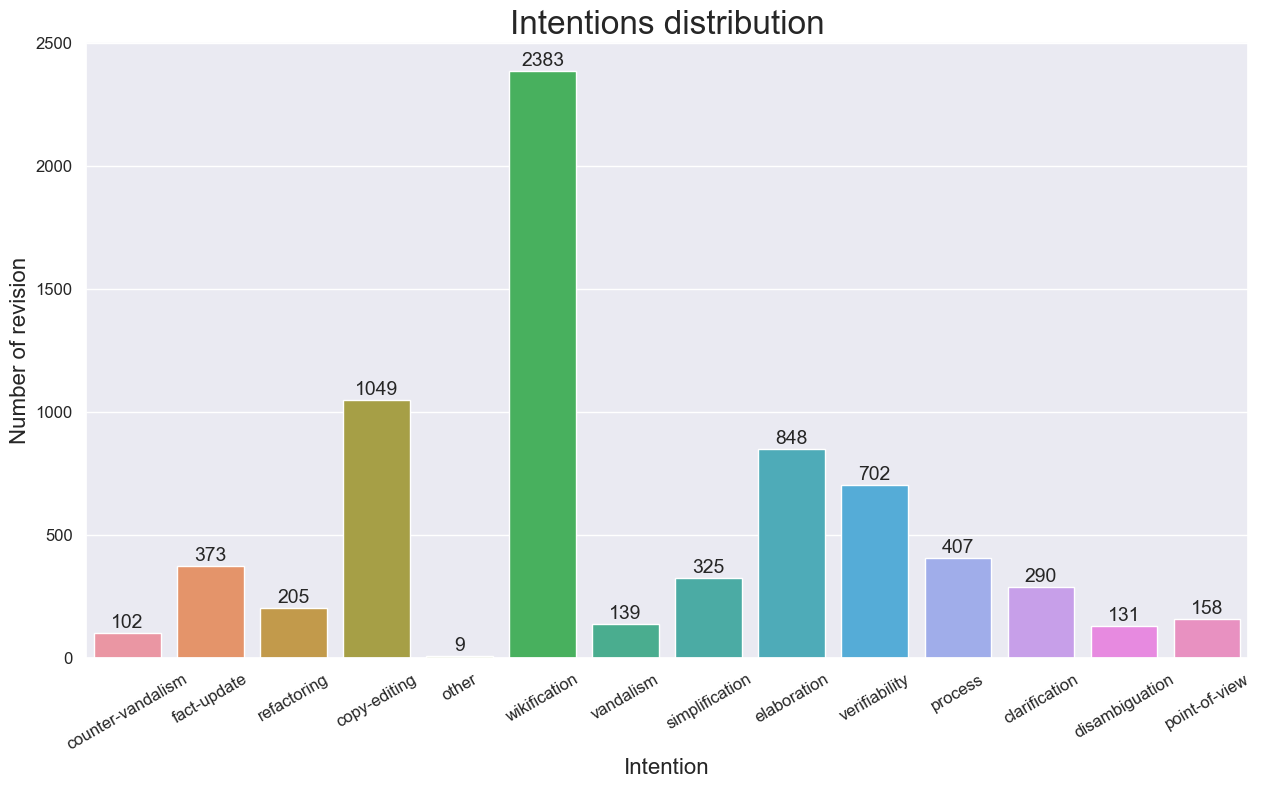

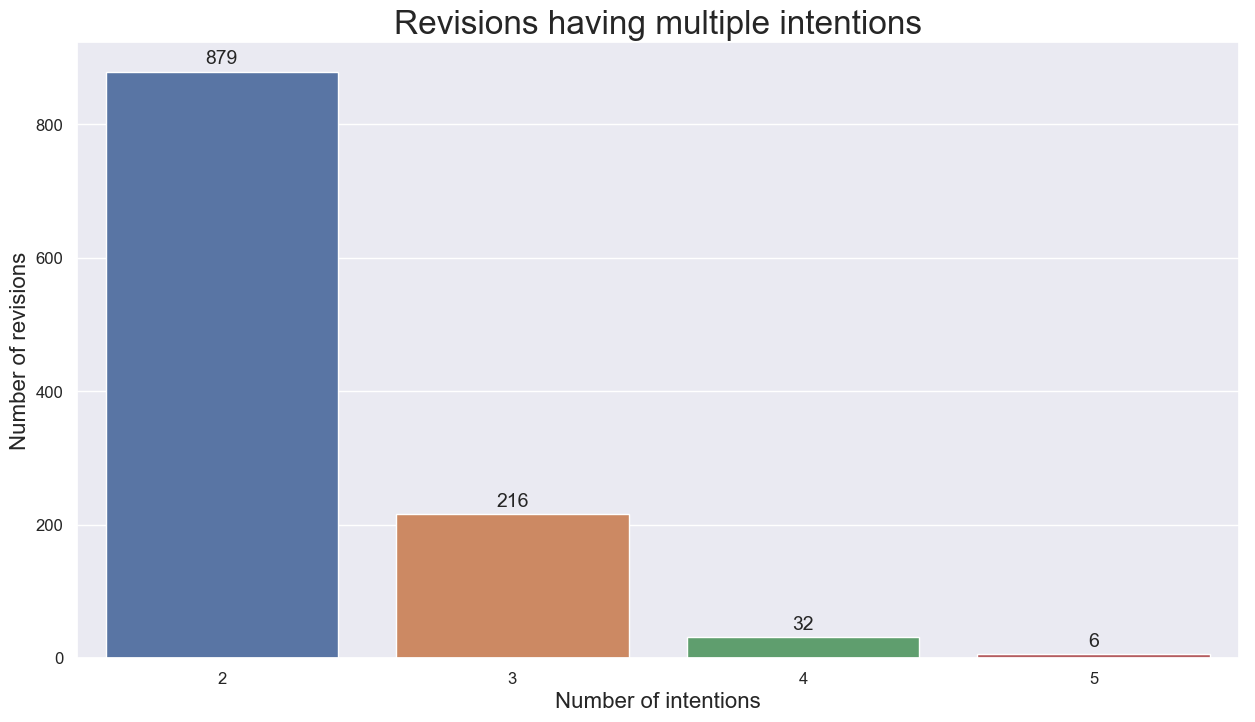

In [78]:
categories = dataset.iloc[:,-14:].columns
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions distribution", fontsize=24)
plt.ylabel('Number of revision', fontsize=16)
plt.xlabel('Intention', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or string like 'vertical'
    tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#adding the text labels
rects = ax.patches
labels = dataset.iloc[:,-14:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
#plt.xticks(intentions,rotation = 30)

plt.show()

rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Revisions having multiple intentions")
plt.ylabel('Number of revisions', fontsize=16)
plt.xlabel('Number of intentions', fontsize=16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#plt.xticks(multiLabel_counts.index, fontsize = 12)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
plt.show()

Se puede ver que el dataset se encuentra poco balanceado, habiendo una clase con mucha más representación que todas las demás: Wikification. Otras como 'Other' solo aparecen originalmente 2 veces en el dataset. Este número fue ampliado manualmente debido a que algoritmos como ADASYM para realizar oversampling necesitan un n >= 6. En cierta manera incluso podríamos considerar esta categoría un Outlier e ignorarla por completo. Se puede ver también que las intenciones no son excluyentes entre sí, habiendo 879 revisiones con 2 intenciones, aunque el número decrece exponencialmente según aumenta el número de intenciones por cada revisión, tocando un mínimo de 6 revisiones con 5 intenciones.

Proporción de labels en el dataset


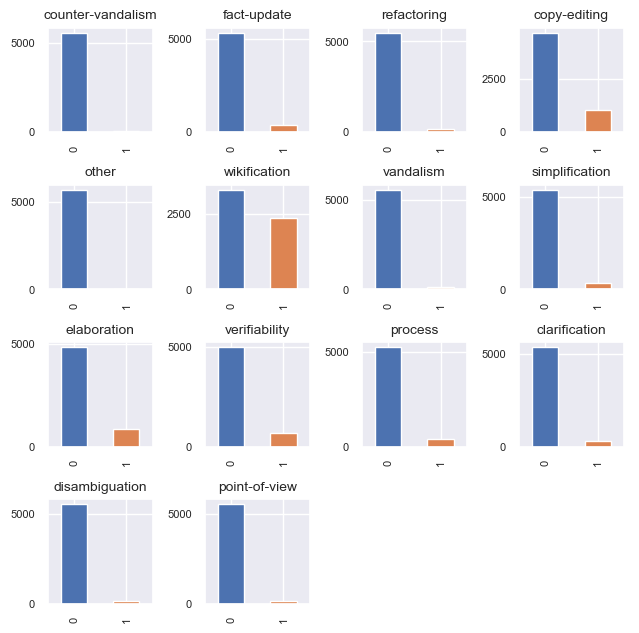

In [79]:

#Charts of the label proportions in the original dataset
print("Proporción de labels en el dataset")
i = 1

for intention in intentions:
    df = pandas.DataFrame(X)
    df['target'] = y[intention]
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    i += 1
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()



Observando cada intencion por separado se aprecia más claramente la falta de balance en el dataset. De cara a realizar un clasificador por intención, alguna estrategia de sampling podría ser necesaria.

In [80]:
rowSums = dataset.iloc[:,-14:].sum(axis=0)
proportions = []
for intention in intentions:
    proportions.append(rowSums[intention]/dataset.shape[0] * 100)

df = pandas.DataFrame({ 'intention':intentions, 'count':rowSums.values, '% of appearance': proportions})
df.head(14)


,intention,count,% of appearance
0,counter-vandalism,102,1.792619
1,fact-update,373,6.555360
2,refactoring,205,3.602812
3,copy-editing,1049,18.435852
4,other,9,0.158172
5,wikification,2383,41.880492
6,vandalism,139,2.442882
7,simplification,325,5.711775
8,elaboration,848,14.903339
9,verifiability,702,12.337434


In [81]:
rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
proportions = []
for i in range(1,6):
    proportions.append(multiLabel_counts[i]/dataset.shape[0] * 100)
df = pandas.DataFrame({ 'Number of intentions':multiLabel_counts.index, 'count':multiLabel_counts.values, '% of appearance': proportions})
df.head(5)

,Number of intentions,count,% of appearance
0,1,4557,80.087873
1,2,879,15.448155
2,3,216,3.796134
3,4,32,0.562390
4,5,6,0.105448


Llegados a este punto, tenemos información suficiente del dataset como para comenzar la clasificación.
El primero modelo será un DummyClassifier utilizado para crear unas métricas de referencia a la hora de evaluar el resto de clasificadores. Se extraerán valores de precision, recall, f1, f1 micro, f1 macro y accuracy. Además se ha eliminado la categoría 'Other'

In [3]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [4]:
#Setting of a dummy model to create a baseline 
#data to collect : Accuracy, precision, recall, f1_score (micro and macro also)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



dummy_precision = []
dummy_recall = []
dummy_f1 = []
dummy_f1_micro = []
dummy_f1_macro = []
dummy_accuracy = []

for intention in intentions:
    
    baseline_model = DummyClassifier(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    dummy_precision.append(precision_score(y_test[intention], y_pred))
    dummy_recall.append(recall_score(y_test[intention], y_pred))
    dummy_f1.append(f1_score(y_test[intention], y_pred))
    dummy_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    dummy_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    dummy_accuracy.append(accuracy_score(y_test[intention], y_pred))
    
dummy_model_data = pandas.DataFrame({'Intention':intentions,'Precision':dummy_precision, 'Recall': dummy_recall
                                     , 'Accuracy':dummy_accuracy, 'F1 Binary':dummy_f1, 'F1 micro': dummy_f1_micro
                                     , 'F1 macro': dummy_f1_macro })
dummy_model_data.head(15)



,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.000000,0.000000,0.971880,0.000000,0.971880,0.492870
1,fact-update,0.070175,0.052632,0.890158,0.060150,0.890158,0.500910
2,refactoring,0.027027,0.023810,0.932337,0.025316,0.932337,0.495134
3,copy-editing,0.162162,0.149254,0.713533,0.155440,0.713533,0.491477
4,wikification,0.410714,0.380952,0.505272,0.395274,0.505272,0.488343
5,vandalism,0.090909,0.060606,0.955185,0.072727,0.955185,0.524882
6,simplification,0.078431,0.055556,0.898946,0.065041,0.898946,0.505813
7,elaboration,0.131034,0.109827,0.753954,0.119497,0.753954,0.488247
8,verifiability,0.043478,0.040000,0.797891,0.041667,0.797891,0.464350
9,process,0.147541,0.107143,0.888401,0.124138,0.888401,0.532271


Los valores obtenidos por el clasificador Dummy son generalmente pobres, con precisiones y recall de 0 en muchos casos. Los valores de accuracy son generalmente altos sin embargo son engañosos debido a la falta de balance del dataset.

El próximo modelo a generar es el Random Forest.

In [84]:
base_rf_precision = []
base_rf_recall = []
base_rf_f1 = []
base_rf_f1_micro = []
base_rf_f1_macro = []
base_rf_accuracy = []

for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_rf_precision.append(precision_score(y_test[intention], y_pred))
    base_rf_recall.append(recall_score(y_test[intention], y_pred))
    base_rf_f1.append(f1_score(y_test[intention], y_pred))
    base_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

base_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision, 'Recall': base_rf_recall
                                     , 'Accuracy':base_rf_accuracy, 'F1 Binary':base_rf_f1, 'F1 micro': base_rf_f1_micro
                                     , 'F1 macro': base_rf_f1_macro })
base_rf_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,1.000000,0.250000,0.989455,0.400000,0.989455,0.697340
1,fact-update,0.791667,0.250000,0.945518,0.380000,0.945518,0.675754
2,refactoring,0.615385,0.190476,0.965729,0.290909,0.965729,0.636675
3,copy-editing,0.760331,0.457711,0.878735,0.571429,0.878735,0.750402
4,wikification,0.784841,0.664596,0.780316,0.719731,0.780316,0.769548
5,vandalism,0.818182,0.272727,0.977153,0.409091,0.977153,0.698721
6,simplification,0.758621,0.305556,0.949912,0.435644,0.949912,0.704718
7,elaboration,0.700000,0.566474,0.897188,0.626198,0.897188,0.783298
8,verifiability,0.793814,0.616000,0.940246,0.693694,0.940246,0.830294
9,process,0.823529,0.333333,0.945518,0.474576,0.945518,0.722923


Los valores obtenidos por el Random Forest son bastante más altos que los del DummyClassifier. No obstante el Recall que mide el número de Positivos reales / (Positivos Reales + Falsos negativos) sigue siendo bastante bajo. Esto implica que el clasificador está asignando más 0's de los que debería. Por el contrario los valores de precision son altos lo cual es explicado precisamente por los bajos valores de recall ya que alta precision implica un bajo valor de falsos positivos.

Además se observa que algunas intenciones son mucho más faciles de detectar por un clasificador que otras, por ejemplo disambiguation o counter-vandalism.

A continuación se generará un modelo usando una SVM con kernel Lineal

In [85]:
base_svc_precision = []
base_svc_recall = []
base_svc_f1 = []
base_svc_f1_micro = []
base_svc_f1_macro = []
base_svc_accuracy = []

for intention in intentions:
    
    baseline_model = LinearSVC(random_state = 64)
    baseline_model.fit(X_train, y_train[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_svc_precision.append(precision_score(y_test[intention], y_pred))
    base_svc_recall.append(recall_score(y_test[intention], y_pred))
    base_svc_f1.append(f1_score(y_test[intention], y_pred))
    base_svc_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_svc_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_svc_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

base_svc_model_data = pandas.DataFrame({'Intention':intentions,'Precision':base_svc_precision, 'Recall': base_svc_recall
                                     , 'Accuracy':base_svc_accuracy, 'F1 Binary':base_svc_f1, 'F1 micro': base_svc_f1_micro
                                     , 'F1 macro': base_svc_f1_macro })
base_svc_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.0,0.000000,0.985940,0.000000,0.985940,0.496460
1,fact-update,0.0,0.000000,0.933216,0.000000,0.933216,0.482727
2,refactoring,0.0,0.000000,0.963093,0.000000,0.963093,0.490600
3,copy-editing,0.0,0.000000,0.823374,0.000000,0.823374,0.451566
4,wikification,0.5,0.488613,0.575571,0.494241,0.575571,0.564304
5,vandalism,0.0,0.000000,0.971002,0.000000,0.971002,0.492644
6,simplification,0.0,0.000000,0.936731,0.000000,0.936731,0.483666
7,elaboration,0.0,0.000000,0.847979,0.000000,0.847979,0.458868
8,verifiability,0.0,0.000000,0.890158,0.000000,0.890158,0.470944
9,process,0.0,0.000000,0.926186,0.000000,0.926186,0.480839


Se puede concluir facilmente con estos resultados que un SVM linear no aporta ninguna utilidad en este dataset.

In [86]:
averages_dummy = []
averages_svc = []
averages_rf = []

for column in dummy_model_data.iloc[:,1:].columns:
    averages_dummy.append(dummy_model_data[column].mean())
    averages_svc.append(base_svc_model_data[column].mean())
    averages_rf.append(base_rf_model_data[column].mean())

base_models_data = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data['Dummy classifier'] = averages_dummy
base_models_data['SVC classifier'] = averages_svc
base_models_data['Random Forest classifier'] = averages_rf
base_models_data.head(15)

,Dummy classifier,SVC classifier,Random Forest classifier
Precision,0.095624,0.038462,0.767028
Recall,0.081285,0.037586,0.334787
Accuracy,0.855820,0.903948,0.936731
F1 Binary,0.087574,0.038019,0.439004
F1 micro,0.855820,0.903948,0.936731
F1 macro,0.498217,0.488205,0.699923


En esta tabla observamos los 3 clasificadores. Se puede ver facilmente que el clasificador con el mejor rendimiento de media es el random Forest, superando claramente al SVC que no pasa el corte al tener resultados inferiores al DummyClassifier tanto en recall como en precision

Ahora, el dataset se va a separar, para que cada intencion tenga un train set diferente y poder realizar over-sampling o feature engineering a medida de cada intencion

In [6]:
#Generation of a "new" train set for each intention, this way we can perform feature engineering specific for each intention
#so that the best features for each intention are selected
X_train_ = {'counter-vandalism':X_train,'fact-update':X_train,'refactoring':X_train,'copy-editing':X_train,'other':X_train,'wikification':X_train,
            'vandalism':X_train,'simplification':X_train,'elaboration':X_train,'verifiability':X_train,'process':X_train,'clarification':X_train,
            'disambiguation':X_train,'point-of-view':X_train}
y_train_ = {}

La técnica a utilizar para balancear el dataset se trata de ADASYN. Una versión mejorada de SMOTE que básicamente genera datos aleatorios de la clase en minoría siguiendo unos parámetros (para que realmente pertenezcan a esa clase)

In [7]:
#Resampling via over_sampling with ADASYN to generate the previously mention new train sets for each intention balanced.
for intention in intentions:
    
    sm = ADASYN()
    X_train_[intention], y_train_[intention] = sm.fit_resample(X_train, y_train[intention])

#Now we have the test and set splits done and the data is ready to be analyzed and modeled.

Proporción de labels en el dataset


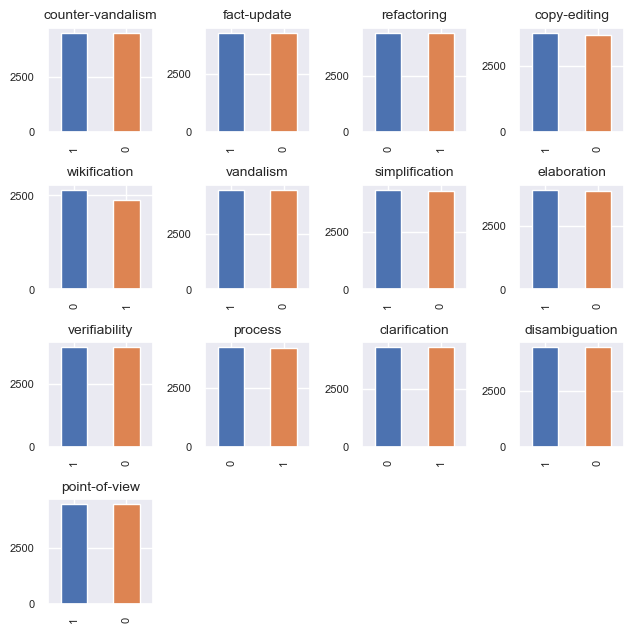

In [89]:

#Charts of the label proportions in the original dataset
print("Proporción de labels en el dataset")
i = 1

for intention in intentions:
    df = pandas.DataFrame(X_train_[intention])
    df['target'] = y_train_[intention]
    plt.subplot(4, 4 , i)
    plt.title(label=intention, fontsize = 10)
    df.target.value_counts().plot(kind='bar');
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    i += 1
plt.subplots_adjust(left=.3, bottom=0.3, right= 1.2, top=1.5, wspace=0.5, hspace=0.5)
plt.show()



Claramente se puede ver como los dataset ahora sí se encuentran balanceados

Ahora, se van a seguir los mismos pasos que antes pero con los datasets balanceados. El primer clasificador es SVM.

In [90]:
base_svc_precision_os = []
base_svc_recall_os = []
base_svc_f1_os = []
base_svc_f1_micro_os = []
base_svc_f1_macro_os = []
base_svc_accuracy_os = []

for intention in intentions:
    
    baseline_model = LinearSVC(random_state = 64)
    baseline_model.fit(X_train_[intention], y_train_[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_svc_precision_os.append(precision_score(y_test[intention], y_pred))
    base_svc_recall_os.append(recall_score(y_test[intention], y_pred))
    base_svc_f1_os.append(f1_score(y_test[intention], y_pred))
    base_svc_f1_micro_os.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_svc_f1_macro_os.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_svc_accuracy_os.append(accuracy_score(y_test[intention], y_pred))
    

base_svc_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':base_svc_precision_os, 'Recall': base_svc_recall_os
                                     , 'Accuracy':base_svc_accuracy_os, 'F1 Binary':base_svc_f1_os, 'F1 micro': base_svc_f1_micro_os
                                     , 'F1 macro': base_svc_f1_macro_os })
base_svc_model_data_os.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.014060,1.0,0.014060,0.027730,0.014060,0.013865
1,fact-update,0.000000,0.0,0.933216,0.000000,0.933216,0.482727
2,refactoring,0.000000,0.0,0.963093,0.000000,0.963093,0.490600
3,copy-editing,0.176626,1.0,0.176626,0.300224,0.176626,0.150112
4,wikification,0.000000,0.0,0.575571,0.000000,0.575571,0.365310
5,vandalism,0.061567,1.0,0.557996,0.115993,0.557996,0.410662
6,simplification,0.063269,1.0,0.063269,0.119008,0.063269,0.059504
7,elaboration,0.152021,1.0,0.152021,0.263921,0.152021,0.131960
8,verifiability,0.000000,0.0,0.890158,0.000000,0.890158,0.470944
9,process,0.073814,1.0,0.073814,0.137480,0.073814,0.068740


Aunque los resultados han mejorado siguen siendo pobres, por lo que claramente el modelo ha seguir va a ser el Random Forest.

Random Forest

In [91]:
base_rf_precision_os = []
base_rf_recall_os = []
base_rf_f1_os = []
base_rf_f1_micro_os = []
base_rf_f1_macro_os = []
base_rf_accuracy_os = []

for intention in intentions:
    
    baseline_model = RandomForestClassifier(random_state = 64)
    baseline_model.fit(X_train_[intention], y_train_[intention])
    
    y_pred = baseline_model.predict(X_test)
    base_rf_precision_os.append(precision_score(y_test[intention], y_pred))
    base_rf_recall_os.append(recall_score(y_test[intention], y_pred))
    base_rf_f1_os.append(f1_score(y_test[intention], y_pred))
    base_rf_f1_micro_os.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    base_rf_f1_macro_os.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    base_rf_accuracy_os.append(accuracy_score(y_test[intention], y_pred))
    

base_rf_model_data_os = pandas.DataFrame({'Intention':intentions,'Precision':base_rf_precision_os, 'Recall': base_rf_recall_os
                                     , 'Accuracy':base_rf_accuracy_os, 'F1 Binary':base_rf_f1_os, 'F1 micro': base_rf_f1_micro_os
                                     , 'F1 macro': base_rf_f1_macro_os })
base_rf_model_data_os.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,1.000000,0.437500,0.992091,0.608696,0.992091,0.802350
1,fact-update,0.576923,0.394737,0.940246,0.468750,0.940246,0.718546
2,refactoring,0.410256,0.380952,0.956942,0.395062,0.956942,0.686369
3,copy-editing,0.625698,0.557214,0.862917,0.589474,0.862917,0.753598
4,wikification,0.782407,0.699793,0.789982,0.738798,0.789982,0.781596
5,vandalism,0.636364,0.424242,0.976274,0.509091,0.976274,0.748467
6,simplification,0.680851,0.444444,0.951670,0.537815,0.951670,0.756158
7,elaboration,0.664706,0.653179,0.897188,0.658892,0.897188,0.799182
8,verifiability,0.671533,0.736000,0.931459,0.702290,0.931459,0.831781
9,process,0.711864,0.500000,0.948155,0.587413,0.948155,0.779876


In [92]:

averages_svc_os = []
averages_rf_os = []

for column in dummy_model_data.iloc[:,1:].columns:

    averages_svc_os.append(base_svc_model_data_os[column].mean())
    averages_rf_os.append(base_rf_model_data_os[column].mean())

base_models_data_os = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data_os['Dummy classifier'] = averages_dummy
base_models_data_os['SVC classifier with OS'] = averages_svc_os
base_models_data_os['Random Forest classifier with OS'] = averages_rf_os
base_models_data_os.head(15)

,Dummy classifier,SVC classifier with OS,Random Forest classifier with OS
Precision,0.095624,0.045969,0.625408
Recall,0.081285,0.615385,0.472061
Accuracy,0.855820,0.416182,0.933351
F1 Binary,0.087574,0.082593,0.529507
F1 micro,0.855820,0.416182,0.933351
F1 macro,0.498217,0.245185,0.744022


Se puede ver en este caso que realmente ha tenido un gran efectivo en las puntuaciones del clasificador SVM, pues su recall ha subido hasta 0.5. Sin embargo en general tiene un rendimiento muy bajo. En cuanto al random forest vemos de nuevo las mejores en general aunque su Recall es más bajo que los otros dos. Sin embargo esto no es necesariamente malo, al tener recall y precision más balanceados que los demás. Un modelo con mucha precisión y muy poco reall tiene muchos Falsos Negativos y muy pocos Falsos Positivos, es decir, tiene muchos valores a los que asignó un 0 pero corresponde un 1 y muy pocos valores en los que asignó un 1 pero era un 0. Y viceversa.

In [93]:
base_models_data_comp = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data_comp['Dummy classifier'] = averages_dummy
base_models_data_comp['SVC classifier'] = averages_svc
base_models_data_comp['Random Forest classifier'] = averages_rf
base_models_data_comp['SVC classifier after over-sampling'] = averages_svc_os
base_models_data_comp['Random Forest classifier after over-sampling'] = averages_rf_os
base_models_data_comp.head(15)

,Dummy classifier,SVC classifier,Random Forest classifier,SVC classifier after over-sampling,Random Forest classifier after over-sampling
Precision,0.095624,0.038462,0.767028,0.045969,0.625408
Recall,0.081285,0.037586,0.334787,0.615385,0.472061
Accuracy,0.855820,0.903948,0.936731,0.416182,0.933351
F1 Binary,0.087574,0.038019,0.439004,0.082593,0.529507
F1 micro,0.855820,0.903948,0.936731,0.416182,0.933351
F1 macro,0.498217,0.488205,0.699923,0.245185,0.744022


Aquí vamos una tabla con todos los clasificadores creados hasta el momento, Dummy, SVM y Random Forest con y sin over-sampling. 
En lineas generales se observa que el Random Forest classifier después del over-sampling es el clasificador con mejor rendimiento, tiene el valor más alto de F1 macro y los valores más balanceados de precision y recall.

Ahora, vamos a proceder a usar el random Forest con Feature engineering y over-sampling. 

In [94]:
scores_all = []
scores_selected = []

fe_rf_precision = []
fe_rf_recall = []
fe_rf_f1 = []
fe_rf_f1_micro = []
fe_rf_f1_macro = []
fe_rf_accuracy = []

for intention in intentions:
    
    #Step to perform feature engineering with the model-based approach
    select = SelectFromModel(
    RandomForestClassifier(random_state = 64),
    threshold=0.01)
    
    select.fit(X_train_[intention], y_train_[intention])
    #Creation of the new train set with the selected attributes
    X_train_l1 = select.transform(X_train_[intention])
    
    #Creation of the model that will fit the data
    lr = RandomForestClassifier(random_state = 64)
    X_test_l1 = select.transform(X_test)
    lr.fit(X_train_l1, y_train_[intention])
    #Calculating the score of the model in the test set with the selected features only
    
    y_pred = lr.predict(X_test_l1)
    fe_rf_precision.append(precision_score(y_test[intention], y_pred))
    fe_rf_recall.append(recall_score(y_test[intention], y_pred))
    fe_rf_f1.append(f1_score(y_test[intention], y_pred))
    fe_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    fe_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    fe_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))
    

fe_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':fe_rf_precision, 'Recall': fe_rf_recall
                                     , 'Accuracy':fe_rf_accuracy, 'F1 Binary':fe_rf_f1, 'F1 micro': fe_rf_f1_micro
                                     , 'F1 macro': fe_rf_f1_macro })
fe_rf_model_data.head(15)


#This is used in the next cell, DataFrame format is given to the scores for easiness in the analysis
#data = pandas.DataFrame({'All features':scores_all,'Selected features':scores_selected})

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.666667,0.375000,0.988576,0.480000,0.988576,0.737112
1,fact-update,0.493671,0.513158,0.932337,0.503226,0.932337,0.733461
2,refactoring,0.410714,0.547619,0.954306,0.469388,0.954306,0.722756
3,copy-editing,0.573604,0.562189,0.848858,0.567839,0.848858,0.738126
4,wikification,0.739437,0.652174,0.754833,0.693069,0.754833,0.744486
5,vandalism,0.470588,0.484848,0.969244,0.477612,0.969244,0.730884
6,simplification,0.518072,0.597222,0.939367,0.554839,0.939367,0.761153
7,elaboration,0.588235,0.693642,0.879613,0.636605,0.879613,0.782231
8,verifiability,0.643836,0.752000,0.927065,0.693727,0.927065,0.826165
9,process,0.610390,0.559524,0.941125,0.583851,0.941125,0.776086


In [95]:
averages_rf_fe = []

for column in dummy_model_data.iloc[:,1:].columns:

    averages_rf_fe.append(fe_rf_model_data[column].mean())


base_models_data_comp_fe = pandas.DataFrame(index = dummy_model_data.iloc[:,1:].columns)
base_models_data_comp_fe['Dummy classifier'] = averages_dummy
base_models_data_comp_fe['Random Forest classifier'] = averages_rf
base_models_data_comp_fe['RF classifier after over-sampling'] = averages_rf_os
base_models_data_comp_fe['RF classifier after feature engineering and over-sampling'] = averages_rf_fe
base_models_data_comp_fe.head(15)

,Dummy classifier,Random Forest classifier,RF classifier after over-sampling,RF classifier after feature engineering and over-sampling
Precision,0.095624,0.767028,0.625408,0.543994
Recall,0.081285,0.334787,0.472061,0.534203
Accuracy,0.855820,0.936731,0.933351,0.923685
F1 Binary,0.087574,0.439004,0.529507,0.532039
F1 micro,0.855820,0.936731,0.933351,0.923685
F1 macro,0.498217,0.699923,0.744022,0.742113


En la tabla podemos ver todos los Random Forest realizados hasta el momento en comparación con el Dummy Classifier. En general se observa como tanto el over-sampling con feature engineering dan lugar a mejores resultados de media que el random forest a secas o el dummy classifier. 
De entre el Random Forest con over-sampling y el Random Forest con over-sampling y feature engineering se observa que hay diferencias ligeras en todos los valores. Está claro que realizar feature engineering genera un efecto sin embargo no es tan claro que sea positivo. Da lugar a que la precision baje pero el recall suba ligeramente. Por otro lado F1 macro también disminuye ligeramente, así como la accuracy y el valor de f1 micro. 
En conclusión feature engineering tras el over sampling a escala general no resulta beneficiosa. Para intenciones específicas si podría generar un valor pero aplicado de modo general, no.

Para ilustrar los valores más claramente, se genera un scatter plot

[]

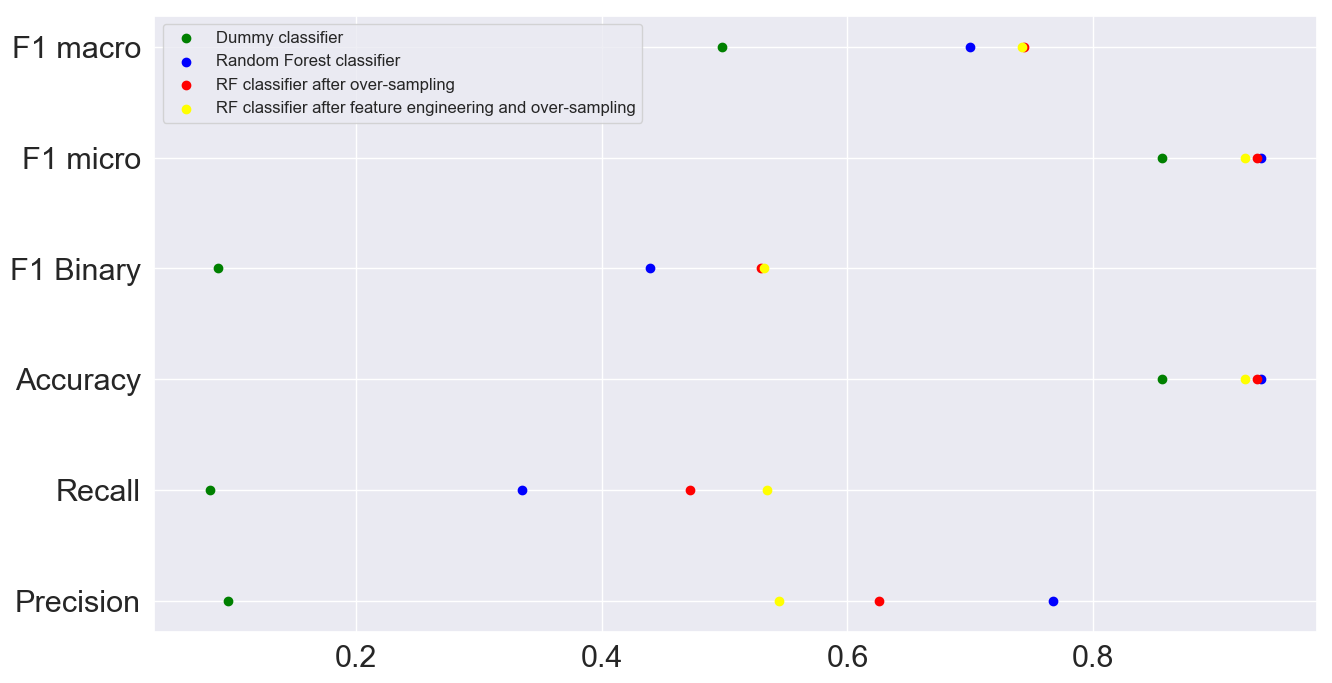

In [96]:
#This visualization shows an scatter plot of the values of the ROC_AUC score for each intention with
#all the attributes and with only the selected attributes in the model-based feature engineering done in the cell above
plt.figure(figsize=(15,8))
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['Dummy classifier'], label = 'Dummy classifier', color= 'green')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['Random Forest classifier'], label =  'Random Forest classifier', color= 'blue')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['RF classifier after over-sampling'], label = 'RF classifier after over-sampling', color = 'red')
plt.scatter(y=base_models_data_comp_fe.index, x = base_models_data_comp_fe['RF classifier after feature engineering and over-sampling'], label = 'RF classifier after feature engineering and over-sampling', color= 'yellow')
plt.legend(loc=2, prop={'size': 12})
plt.plot()


Visualmente se ve más claramente que en precision, f1, f1 macro, micro and accuracy los valores sin feature engineering son mayores.

In [97]:
feature_results_comparison = base_rf_model_data_os.merge(fe_rf_model_data, left_on='Intention', right_on='Intention',
                               suffixes=('_os', '_fe'))

feature_results_comparison = feature_results_comparison.drop(axis = 1, labels = ['Accuracy_os','Accuracy_fe', 'F1 micro_os','F1 micro_fe'])
feature_results_comparison.head(15)

,Intention,Precision_os,Recall_os,F1 Binary_os,F1 macro_os,Precision_fe,Recall_fe,F1 Binary_fe,F1 macro_fe
0,counter-vandalism,1.000000,0.437500,0.608696,0.802350,0.666667,0.375000,0.480000,0.737112
1,fact-update,0.576923,0.394737,0.468750,0.718546,0.493671,0.513158,0.503226,0.733461
2,refactoring,0.410256,0.380952,0.395062,0.686369,0.410714,0.547619,0.469388,0.722756
3,copy-editing,0.625698,0.557214,0.589474,0.753598,0.573604,0.562189,0.567839,0.738126
4,wikification,0.782407,0.699793,0.738798,0.781596,0.739437,0.652174,0.693069,0.744486
5,vandalism,0.636364,0.424242,0.509091,0.748467,0.470588,0.484848,0.477612,0.730884
6,simplification,0.680851,0.444444,0.537815,0.756158,0.518072,0.597222,0.554839,0.761153
7,elaboration,0.664706,0.653179,0.658892,0.799182,0.588235,0.693642,0.636605,0.782231
8,verifiability,0.671533,0.736000,0.702290,0.831781,0.643836,0.752000,0.693727,0.826165
9,process,0.711864,0.500000,0.587413,0.779876,0.610390,0.559524,0.583851,0.776086


Esta tabla de arriba sirve para comparar en cada intención cada métrica entre el modelo con feature engineering y el modelo sin feature engineering

In [8]:
from sklearn.model_selection import GridSearchCV
#Random Forest Optimization
#Parameters to optimize in the random forest, the amount of estimators, which means number of trees in the forest
parameters = {'n_estimators' : [1,2,4,8,16,32,64,128,256,512]}

tuning_rf_precision = []
tuning_rf_recall = []
tuning_rf_f1 = []
tuning_rf_f1_macro = []
tuning_rf_f1_micro = []
tuning_rf_accuracy = []

cv_results_rf_tuning = []
models = []

#Loop for each intention
for intention in intentions:
    
    grid_rf = GridSearchCV(RandomForestClassifier(random_state = 64), parameters, cv = 10, scoring = 'f1_macro')
    #fitted on the train set specific for each intention
    grid_rf.fit(X_train_[intention],y_train_[intention])
    df = pandas.DataFrame(grid_rf.cv_results_) 
    cv_results_rf_tuning.append(df)
    models.append(grid_rf)
    #Predictions of the train set (expected to see clear overfitting in the results as im predicting the train set)

    #Now we predict the labels for the new test set and calculate its roc_auc score
    y_pred = grid_rf.predict(X_test)
    tuning_rf_precision.append(precision_score(y_test[intention], y_pred))
    tuning_rf_recall.append(recall_score(y_test[intention], y_pred))
    tuning_rf_f1.append(f1_score(y_test[intention], y_pred))
    tuning_rf_f1_micro.append(f1_score(y_test[intention], y_pred, average = 'micro'))
    tuning_rf_f1_macro.append(f1_score(y_test[intention], y_pred, average = 'macro'))
    tuning_rf_accuracy.append(accuracy_score(y_test[intention], y_pred))

tuning_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':tuning_rf_precision, 'Recall': tuning_rf_recall
                                     , 'Accuracy':tuning_rf_accuracy, 'F1 Binary':tuning_rf_f1, 'F1 micro': tuning_rf_f1_micro
                                     , 'F1 macro': tuning_rf_f1_macro })
tuning_rf_model_data.head(15)

,Intention,Precision,Recall,Accuracy,F1 Binary,F1 micro,F1 macro
0,counter-vandalism,0.777778,0.437500,0.990334,0.560000,0.990334,0.777557
1,fact-update,0.532258,0.434211,0.936731,0.478261,0.936731,0.722292
2,refactoring,0.483871,0.357143,0.962214,0.410959,0.962214,0.695720
3,copy-editing,0.634615,0.656716,0.872583,0.645477,0.872583,0.783906
4,wikification,0.773196,0.776398,0.808436,0.774793,0.808436,0.804063
5,vandalism,0.538462,0.424242,0.972759,0.474576,0.972759,0.730297
6,simplification,0.634921,0.555556,0.951670,0.592593,0.951670,0.783452
7,elaboration,0.638743,0.705202,0.894552,0.670330,0.894552,0.803784
8,verifiability,0.700000,0.784000,0.939367,0.739623,0.939367,0.852656
9,process,0.724138,0.500000,0.949033,0.591549,0.949033,0.782185


In [99]:
for dataframe,intention in zip(cv_results_rf_tuning,intentions):
    print(intention + ' Cross Validation results using f1-macro averaged')
    display(dataframe.head(100))

counter-vandalism Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.055979,0.013749,0.002848,0.002197,1,{'n_estimators': 1},0.964222,0.977652,0.976536,0.957533,...,0.992920,0.994535,0.991678,0.994162,0.993666,0.993045,0.990685,0.990934,0.993119,0.001512
1,0.104442,0.009570,0.006208,0.006502,2,{'n_estimators': 2},0.946233,0.979884,0.978767,0.936113,...,0.996771,0.995404,0.996150,0.995156,0.995032,0.995281,0.994535,0.994908,0.995367,0.000770
2,0.201150,0.015901,0.004601,0.006586,4,{'n_estimators': 4},0.960837,0.981001,0.987709,0.923668,...,0.999255,0.999379,0.999131,0.999131,0.998634,0.998385,0.998882,0.998758,0.998882,0.000351
3,0.364564,0.029550,0.004197,0.001682,8,{'n_estimators': 8},0.960844,0.998883,0.992179,0.932688,...,0.999752,0.999503,0.999503,0.999503,0.999379,0.999627,0.999627,0.999503,0.999540,0.000112
4,0.618905,0.070620,0.006347,0.001704,16,{'n_estimators': 16},0.968687,0.998883,0.997765,0.930444,...,0.999876,0.999876,0.999752,0.999752,0.999752,0.999876,0.999876,0.999876,0.999826,0.000099
5,1.255870,0.083520,0.011316,0.002690,32,{'n_estimators': 32},0.972047,0.998883,0.997765,0.929312,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999876,0.999876,0.999975,0.000050
6,2.669485,0.054279,0.017806,0.002999,64,{'n_estimators': 64},0.972047,0.998883,0.997765,0.928180,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,5.383345,0.187021,0.037303,0.013456,128,{'n_estimators': 128},0.976525,0.998883,0.997765,0.925935,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,10.472635,0.325832,0.065899,0.005794,256,{'n_estimators': 256},0.975405,0.998883,0.997765,0.924802,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,20.952985,0.342512,0.129032,0.011035,512,{'n_estimators': 512},0.975405,0.998883,0.997765,0.925913,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


fact-update Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.074497,0.008601,0.002007,0.001526,1,{'n_estimators': 1},0.777003,0.924925,0.928484,0.907361,...,0.971570,0.973135,0.972613,0.975095,0.972881,0.971838,0.971968,0.974315,0.973816,0.002961
1,0.123016,0.009891,0.002230,0.000960,2,{'n_estimators': 2},0.721702,0.934284,0.905850,0.908366,...,0.974687,0.975733,0.977301,0.977173,0.975089,0.975220,0.977047,0.979786,0.977068,0.003160
2,0.241847,0.033155,0.004025,0.001397,4,{'n_estimators': 4},0.782697,0.958954,0.960138,0.940208,...,0.991001,0.992566,0.990610,0.991524,0.992438,0.991004,0.991525,0.992308,0.992163,0.001444
3,0.443314,0.019783,0.004478,0.001324,8,{'n_estimators': 8},0.811287,0.977726,0.975380,0.957795,...,0.996870,0.996870,0.995696,0.997001,0.997523,0.996219,0.996871,0.997001,0.997079,0.000937
4,0.864477,0.069433,0.006272,0.001107,16,{'n_estimators': 16},0.843531,0.981242,0.983587,0.962484,...,0.998826,0.998957,0.998957,0.999478,0.999087,0.999218,0.999348,0.999478,0.999257,0.000325
5,1.698680,0.064404,0.012046,0.001419,32,{'n_estimators': 32},0.857071,0.980070,0.982413,0.969516,...,0.999870,1.000000,0.999739,0.999739,0.999609,0.999609,0.999609,0.999478,0.999752,0.000169
6,3.303882,0.071629,0.021209,0.001849,64,{'n_estimators': 64},0.858387,0.975381,0.983585,0.968344,...,1.000000,1.000000,0.999739,1.000000,1.000000,0.999870,1.000000,0.999870,0.999948,0.000086
7,6.554559,0.110964,0.033963,0.007095,128,{'n_estimators': 128},0.855923,0.976553,0.985930,0.968343,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,12.737675,0.513347,0.079974,0.005003,256,{'n_estimators': 256},0.859618,0.976553,0.987102,0.970688,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,25.820994,1.004330,0.151049,0.019064,512,{'n_estimators': 512},0.859618,0.975380,0.984757,0.969516,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


refactoring Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.073134,0.007907,0.002834,0.001690,1,{'n_estimators': 1},0.878463,0.931408,0.946285,0.961139,...,0.982730,0.982984,0.985397,0.985650,0.985270,0.983873,0.985524,0.987176,0.984609,0.001344
1,0.133669,0.017230,0.002261,0.000658,2,{'n_estimators': 2},0.862019,0.945022,0.942766,0.933451,...,0.984886,0.982725,0.986537,0.985011,0.987172,0.984503,0.984757,0.989206,0.986054,0.001963
2,0.250969,0.017371,0.003266,0.000715,4,{'n_estimators': 4},0.895223,0.974848,0.978286,0.961081,...,0.996571,0.995682,0.996825,0.995047,0.995682,0.995682,0.995936,0.997334,0.996241,0.000895
3,0.495791,0.048190,0.003559,0.000941,8,{'n_estimators': 8},0.912747,0.978277,0.989714,0.975990,...,0.998349,0.997841,0.998476,0.998095,0.998095,0.997968,0.998095,0.998730,0.998235,0.000423
4,0.943790,0.075202,0.006259,0.001555,16,{'n_estimators': 16},0.924326,0.982854,0.992000,0.983998,...,0.999873,0.999619,0.999873,0.999746,0.999873,0.999746,0.999619,0.999873,0.999797,0.000116
5,1.976065,0.122058,0.010936,0.003442,32,{'n_estimators': 32},0.932419,0.980568,0.990857,0.980569,...,0.999873,0.999746,0.999873,1.000000,0.999746,0.999873,1.000000,0.999873,0.999886,0.000089
6,4.180115,0.140767,0.020507,0.000821,64,{'n_estimators': 64},0.933607,0.980568,0.990857,0.985142,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,8.095299,0.268513,0.035462,0.004947,128,{'n_estimators': 128},0.933607,0.980568,0.992000,0.987428,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,16.507453,0.666993,0.075699,0.011781,256,{'n_estimators': 256},0.932454,0.981711,0.992000,0.989714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,35.379466,1.887083,0.162472,0.020069,512,{'n_estimators': 512},0.933607,0.980568,0.992000,0.989714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


copy-editing Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.054026,0.003463,0.001409,0.001318,1,{'n_estimators': 1},0.761954,0.718498,0.846444,0.876931,...,0.944301,0.941178,0.949205,0.938816,0.939260,0.935543,0.943424,0.945500,0.943191,0.004300
1,0.086938,0.005805,0.002389,0.001967,2,{'n_estimators': 2},0.684647,0.674623,0.838494,0.870160,...,0.938562,0.940493,0.944242,0.937368,0.939171,0.936018,0.944693,0.943955,0.942354,0.004629
2,0.168471,0.033147,0.002823,0.001665,4,{'n_estimators': 4},0.744595,0.715491,0.887725,0.914545,...,0.979504,0.980098,0.982774,0.978912,0.980992,0.980398,0.983222,0.980549,0.981377,0.001709
3,0.309148,0.023635,0.004335,0.001257,8,{'n_estimators': 8},0.794724,0.777028,0.931909,0.943903,...,0.995990,0.994059,0.995099,0.994357,0.995545,0.995099,0.994803,0.994654,0.995218,0.000751
4,0.525783,0.070603,0.006451,0.001691,16,{'n_estimators': 16},0.809622,0.793151,0.931901,0.950510,...,0.998366,0.998366,0.998812,0.997772,0.998663,0.998218,0.998218,0.999109,0.998530,0.000401
5,1.164873,0.070599,0.011409,0.002940,32,{'n_estimators': 32},0.834991,0.805235,0.939885,0.959878,...,0.999554,0.999851,0.999703,0.999851,1.000000,0.999554,0.999555,0.999703,0.999733,0.000173
6,2.252750,0.179209,0.020674,0.002883,64,{'n_estimators': 64},0.848870,0.820483,0.942557,0.954518,...,1.000000,1.000000,1.000000,0.999851,1.000000,0.999851,0.999852,0.999852,0.999941,0.000073
7,4.341643,0.225928,0.038049,0.008919,128,{'n_estimators': 128},0.849261,0.828859,0.937195,0.957183,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,8.583864,0.414877,0.078582,0.013832,256,{'n_estimators': 256},0.851650,0.835880,0.941200,0.955828,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,17.356640,0.895617,0.145039,0.016223,512,{'n_estimators': 512},0.855735,0.834573,0.942541,0.958505,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


wikification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.027706,0.002721,0.001507,0.000677,1,{'n_estimators': 1},0.688707,0.701813,0.719145,0.727835,...,0.892890,0.895162,0.900527,0.887261,0.895386,0.897514,0.894685,0.894007,0.895266,0.003555
1,0.046813,0.003142,0.002178,0.000518,2,{'n_estimators': 2},0.677861,0.670065,0.704832,0.715064,...,0.895226,0.897902,0.902818,0.893434,0.896962,0.901178,0.892357,0.897051,0.897164,0.003206
2,0.094378,0.013412,0.003465,0.001704,4,{'n_estimators': 4},0.726077,0.749407,0.721898,0.738195,...,0.956757,0.952300,0.953184,0.953870,0.954540,0.951846,0.953855,0.956112,0.954466,0.002171
3,0.162701,0.021573,0.003304,0.001409,8,{'n_estimators': 8},0.747522,0.763546,0.753823,0.781076,...,0.983116,0.984020,0.982461,0.984678,0.984456,0.983794,0.982457,0.984233,0.983856,0.001027
4,0.356000,0.054693,0.004924,0.001211,16,{'n_estimators': 16},0.785140,0.794859,0.780959,0.792681,...,0.994896,0.996451,0.995341,0.995786,0.996451,0.996229,0.995341,0.996007,0.995762,0.000530
5,0.622802,0.043898,0.008547,0.002593,32,{'n_estimators': 32},0.781666,0.805184,0.803866,0.805475,...,0.998891,0.999556,0.999113,0.998891,0.999335,0.999778,0.998669,0.998891,0.999179,0.000330
6,1.255140,0.077284,0.020020,0.010461,64,{'n_estimators': 64},0.798396,0.808934,0.818350,0.799649,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999778,0.999978,0.000067
7,2.779691,0.182005,0.032988,0.013251,128,{'n_estimators': 128},0.802131,0.805037,0.830561,0.811670,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,5.186477,0.342595,0.065831,0.020507,256,{'n_estimators': 256},0.810487,0.803006,0.834548,0.811670,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,10.433574,0.474421,0.115987,0.015881,512,{'n_estimators': 512},0.810595,0.804954,0.836507,0.807663,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


vandalism Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.057738,0.005882,0.002142,0.000827,1,{'n_estimators': 1},0.921214,0.979820,0.982063,0.979821,...,0.992522,0.990778,0.994018,0.992148,0.992399,0.991028,0.993022,0.991277,0.992398,0.001335
1,0.107639,0.032597,0.002290,0.001065,2,{'n_estimators': 2},0.890061,0.973089,0.970834,0.969711,...,0.991899,0.992148,0.994143,0.993145,0.993645,0.993271,0.993022,0.990778,0.992971,0.001399
2,0.182575,0.026037,0.002799,0.001348,4,{'n_estimators': 4},0.918838,0.984305,0.991031,0.983182,...,0.997632,0.997757,0.998380,0.997258,0.998380,0.998006,0.998131,0.997508,0.998006,0.000479
3,0.334936,0.040214,0.005506,0.005027,8,{'n_estimators': 8},0.927946,0.991031,0.994394,0.997758,...,0.999501,0.999377,0.999252,0.999501,0.999128,0.999377,0.999377,0.999377,0.999414,0.000185
4,0.654038,0.055098,0.005202,0.001451,16,{'n_estimators': 16},0.932450,0.993273,0.998879,0.997758,...,0.999875,0.999751,0.999626,0.999751,0.999751,0.999626,0.999751,0.999751,0.999763,0.000104
5,1.275475,0.041351,0.009785,0.002432,32,{'n_estimators': 32},0.935872,0.993273,1.000000,0.995515,...,0.999875,1.000000,0.999875,0.999875,0.999875,0.999875,0.999875,0.999875,0.999913,0.000057
6,2.384122,0.159710,0.015964,0.002342,64,{'n_estimators': 64},0.937022,0.993273,1.000000,0.996637,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,4.999359,0.168286,0.031225,0.002259,128,{'n_estimators': 128},0.937006,0.993273,1.000000,0.993273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,10.139713,0.436062,0.071305,0.018450,256,{'n_estimators': 256},0.939271,0.993273,1.000000,0.993273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,21.106341,0.575922,0.130716,0.018517,512,{'n_estimators': 512},0.939271,0.993273,1.000000,0.993273,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


simplification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.085667,0.020085,0.003006,0.001612,1,{'n_estimators': 1},0.849845,0.923611,0.920139,0.944443,...,0.976069,0.977741,0.974269,0.975426,0.979672,0.980444,0.980318,0.976462,0.978232,0.002429
1,0.135211,0.033437,0.002804,0.000969,2,{'n_estimators': 2},0.818485,0.931601,0.917673,0.937443,...,0.980057,0.982631,0.979284,0.980700,0.982244,0.980442,0.984048,0.979418,0.981344,0.002180
2,0.249747,0.035943,0.003258,0.000692,4,{'n_estimators': 4},0.872779,0.961806,0.962963,0.975693,...,0.994339,0.995240,0.993696,0.994211,0.996140,0.995111,0.996913,0.993698,0.995099,0.001039
3,0.527638,0.103792,0.005595,0.001913,8,{'n_estimators': 8},0.881293,0.974532,0.965273,0.976842,...,0.998585,0.997813,0.997041,0.998328,0.999228,0.998328,0.999228,0.998457,0.998443,0.000639
4,0.951033,0.077621,0.005898,0.001309,16,{'n_estimators': 16},0.899032,0.976847,0.972215,0.980312,...,0.999614,0.999228,0.999357,0.999485,0.999743,0.999743,0.999743,0.999614,0.999550,0.000201
5,1.876895,0.117075,0.011147,0.004142,32,{'n_estimators': 32},0.903697,0.975687,0.975680,0.977996,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999871,1.000000,0.999743,0.999949,0.000085
6,3.556477,0.121652,0.020414,0.008255,64,{'n_estimators': 64},0.913035,0.978001,0.973361,0.979153,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,7.039843,0.230014,0.039937,0.016632,128,{'n_estimators': 128},0.917704,0.978001,0.977994,0.980312,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,14.907037,1.153162,0.068960,0.009810,256,{'n_estimators': 256},0.916522,0.976839,0.976834,0.980312,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,32.807167,2.858964,0.159972,0.011319,512,{'n_estimators': 512},0.913052,0.976842,0.979153,0.979153,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


elaboration Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.069535,0.008599,0.002604,0.001803,1,{'n_estimators': 1},0.783234,0.815427,0.897689,0.916959,...,0.961632,0.958509,0.959648,0.956808,0.956525,0.963062,0.963771,0.960367,0.960402,0.002705
1,0.120083,0.007957,0.002012,0.001782,2,{'n_estimators': 2},0.725552,0.788542,0.918193,0.907882,...,0.958767,0.955340,0.956356,0.954359,0.955499,0.962909,0.963763,0.957638,0.959028,0.003586
2,0.220584,0.013393,0.003810,0.002062,4,{'n_estimators': 4},0.772389,0.845324,0.943801,0.951446,...,0.985507,0.986928,0.984373,0.985083,0.984941,0.986932,0.986790,0.986222,0.986077,0.001168
3,0.401227,0.025421,0.005044,0.001936,8,{'n_estimators': 8},0.809747,0.862831,0.951440,0.956552,...,0.995311,0.994458,0.993465,0.994459,0.993323,0.994744,0.994318,0.993750,0.994601,0.001022
4,0.791812,0.049947,0.007437,0.001654,16,{'n_estimators': 16},0.834845,0.877202,0.962922,0.961633,...,0.998437,0.998579,0.998863,0.998721,0.997869,0.998437,0.998153,0.998011,0.998466,0.000335
5,1.576315,0.053311,0.013934,0.002347,32,{'n_estimators': 32},0.850759,0.877120,0.968031,0.957775,...,1.000000,0.999716,0.999858,0.999858,0.999858,1.000000,0.999858,0.999716,0.999830,0.000124
6,3.140342,0.073259,0.021999,0.002977,64,{'n_estimators': 64},0.852013,0.892573,0.962885,0.964176,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999986,0.000043
7,6.224672,0.092857,0.044140,0.003471,128,{'n_estimators': 128},0.856028,0.893880,0.964169,0.962893,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,12.366627,0.199646,0.084256,0.008765,256,{'n_estimators': 256},0.859970,0.886189,0.965452,0.962893,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,23.905382,1.721166,0.154785,0.022580,512,{'n_estimators': 512},0.865211,0.892593,0.964169,0.962893,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


verifiability Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.073250,0.008206,0.002589,0.004672,1,{'n_estimators': 1},0.845837,0.895712,0.942263,0.938434,...,0.973467,0.970679,0.973611,0.971241,0.973893,0.975848,0.978081,0.973334,0.974561,0.002898
1,0.127912,0.009381,0.002794,0.004608,2,{'n_estimators': 2},0.759118,0.886367,0.942251,0.939668,...,0.974155,0.971640,0.975836,0.974861,0.975001,0.974162,0.977517,0.975002,0.975571,0.002292
2,0.245939,0.022538,0.001850,0.001857,4,{'n_estimators': 4},0.816131,0.910618,0.958594,0.963568,...,0.991761,0.989807,0.990366,0.990367,0.991623,0.992182,0.992880,0.992322,0.991720,0.001143
3,0.438649,0.029624,0.006383,0.006110,8,{'n_estimators': 8},0.846556,0.927117,0.969887,0.962306,...,0.995811,0.996649,0.996090,0.995672,0.995533,0.995951,0.996789,0.996510,0.996328,0.000572
4,0.864349,0.114226,0.005730,0.005007,16,{'n_estimators': 16},0.864642,0.938481,0.976158,0.966076,...,0.998604,0.998464,0.998604,0.998744,0.998883,0.999023,0.998604,0.999162,0.998827,0.000326
5,1.567082,0.067291,0.010261,0.002628,32,{'n_estimators': 32},0.874978,0.941005,0.977412,0.966071,...,0.999302,0.999302,0.999302,0.999721,0.999442,0.999721,0.999302,0.999860,0.999539,0.000250
6,3.450686,0.228980,0.018512,0.004760,64,{'n_estimators': 64},0.873790,0.940999,0.978667,0.969840,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999860,0.999721,1.000000,0.999958,0.000089
7,7.169204,0.251439,0.040058,0.005886,128,{'n_estimators': 128},0.878885,0.940999,0.981176,0.971092,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,14.074283,0.719117,0.077944,0.014352,256,{'n_estimators': 256},0.881493,0.943516,0.983687,0.972351,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,27.565013,1.292651,0.149684,0.024563,512,{'n_estimators': 512},0.881451,0.944773,0.982432,0.971095,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


process Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.064399,0.008875,0.000604,0.001198,1,{'n_estimators': 1},0.790196,0.908424,0.915572,0.917851,...,0.970771,0.972097,0.970246,0.967071,0.970378,0.967072,0.968262,0.966018,0.969147,0.001845
1,0.114072,0.011569,0.001975,0.004746,2,{'n_estimators': 2},0.743132,0.916434,0.901836,0.908962,...,0.969679,0.974456,0.974455,0.970742,0.973529,0.975387,0.971407,0.972735,0.972546,0.002127
2,0.214987,0.029843,0.002803,0.004982,4,{'n_estimators': 4},0.793025,0.953568,0.947627,0.948720,...,0.993122,0.994445,0.994710,0.993122,0.992593,0.993916,0.993784,0.992594,0.993400,0.001289
3,0.392106,0.035834,0.005029,0.005854,8,{'n_estimators': 8},0.818493,0.973838,0.967894,0.969039,...,0.998148,0.998545,0.998678,0.999207,0.998149,0.997884,0.997752,0.997620,0.998175,0.000588
4,0.773807,0.035588,0.004397,0.005720,16,{'n_estimators': 16},0.834753,0.985731,0.972649,0.976186,...,0.999339,0.999736,0.999736,0.999736,0.999603,0.999471,0.999471,0.999471,0.999524,0.000198
5,1.491603,0.104330,0.008054,0.006233,32,{'n_estimators': 32},0.840158,0.984542,0.972649,0.980948,...,0.999868,0.999868,0.999868,1.000000,0.999736,0.999868,0.999736,0.999736,0.999828,0.000085
6,2.996706,0.115608,0.020030,0.005927,64,{'n_estimators': 64},0.842682,0.986920,0.971462,0.985713,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999987,0.000040
7,6.017274,0.130025,0.046499,0.005797,128,{'n_estimators': 128},0.846163,0.986920,0.978596,0.983331,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,11.762778,0.403764,0.085681,0.008487,256,{'n_estimators': 256},0.846163,0.985731,0.977406,0.986904,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,23.225022,1.234550,0.168438,0.015401,512,{'n_estimators': 512},0.848585,0.989298,0.973840,0.986904,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


clarification Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.077025,0.012397,0.001416,0.001112,1,{'n_estimators': 1},0.792380,0.912892,0.922177,0.916376,...,0.973381,0.975966,0.968734,0.974289,0.975326,0.971192,0.973647,0.972225,0.973527,0.002887
1,0.136631,0.021869,0.001640,0.001706,2,{'n_estimators': 2},0.750531,0.916082,0.931261,0.905494,...,0.976340,0.976728,0.973107,0.976861,0.975052,0.971817,0.975830,0.975570,0.976162,0.003130
2,0.257258,0.021481,0.003196,0.001764,4,{'n_estimators': 4},0.815616,0.968637,0.961637,0.955839,...,0.992117,0.993151,0.992506,0.993152,0.991732,0.992894,0.991990,0.994057,0.993049,0.001407
3,0.481973,0.046284,0.004944,0.001686,8,{'n_estimators': 8},0.835803,0.980255,0.980253,0.969799,...,0.996770,0.997545,0.997545,0.997933,0.997416,0.997675,0.997029,0.997545,0.997584,0.000676
4,0.966842,0.062872,0.006654,0.002646,16,{'n_estimators': 16},0.820699,0.984901,0.982578,0.982578,...,0.999095,0.999483,0.999096,0.999225,0.999742,0.999483,0.999225,0.999225,0.999328,0.000346
5,1.928154,0.107325,0.009313,0.003610,32,{'n_estimators': 32},0.835682,0.988386,0.987224,0.986063,...,0.999871,1.000000,0.999742,1.000000,0.999871,1.000000,1.000000,1.000000,0.999935,0.000087
6,3.778405,0.174870,0.022047,0.005564,64,{'n_estimators': 64},0.839432,0.988385,0.989547,0.993031,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,8.103266,0.174861,0.045369,0.004005,128,{'n_estimators': 128},0.840679,0.989547,0.988386,0.991870,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,15.975101,0.582321,0.087536,0.010308,256,{'n_estimators': 256},0.843057,0.989547,0.988385,0.990708,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,32.334343,0.631562,0.159914,0.022358,512,{'n_estimators': 512},0.841925,0.989547,0.988385,0.990708,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


disambiguation Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.068434,0.008253,0.002858,0.004987,1,{'n_estimators': 1},0.891679,0.918865,0.968538,0.941537,...,0.991635,0.991261,0.989388,0.990137,0.991386,0.988889,0.990012,0.989639,0.990225,0.000863
1,0.121714,0.012638,0.002079,0.003205,2,{'n_estimators': 2},0.842572,0.908338,0.978642,0.943718,...,0.993633,0.993383,0.992010,0.990761,0.992634,0.990511,0.991885,0.991386,0.992060,0.000967
2,0.225593,0.012301,0.005432,0.007303,4,{'n_estimators': 4},0.875841,0.925504,0.993258,0.958394,...,0.998127,0.998127,0.997878,0.997129,0.998002,0.997628,0.998377,0.998128,0.997953,0.000341
3,0.416186,0.021900,0.003555,0.004938,8,{'n_estimators': 8},0.914094,0.925569,0.988763,0.993258,...,0.999501,0.999501,0.999376,0.999376,0.999126,0.999376,0.999126,0.999126,0.999376,0.000193
4,0.820595,0.067674,0.006112,0.006735,16,{'n_estimators': 16},0.910651,0.932371,0.998876,0.994382,...,0.999625,0.999750,0.999750,0.999501,0.999875,0.999750,0.999750,1.000000,0.999775,0.000134
5,1.581229,0.096495,0.012562,0.005095,32,{'n_estimators': 32},0.916386,0.951619,0.998876,0.994382,...,0.999750,0.999875,0.999875,1.000000,1.000000,1.000000,1.000000,1.000000,0.999925,0.000100
6,3.200870,0.058625,0.022338,0.006702,64,{'n_estimators': 64},0.919819,0.967401,1.000000,0.993258,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,6.418976,0.176069,0.039231,0.007877,128,{'n_estimators': 128},0.924389,0.934625,1.000000,0.994382,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,11.967448,0.942154,0.072791,0.010490,256,{'n_estimators': 256},0.927810,0.939163,0.998876,0.994382,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,25.186767,0.750084,0.164152,0.028562,512,{'n_estimators': 512},0.926670,0.950481,0.998876,0.994382,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


point-of-view Cross Validation results using f1-macro averaged


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.079746,0.009368,0.002499,0.001246,1,{'n_estimators': 1},0.905080,0.927928,0.961705,0.943693,...,0.981976,0.981977,0.980725,0.983354,0.984230,0.981476,0.981603,0.983481,0.982665,0.001941
1,0.138034,0.013996,0.003151,0.004895,2,{'n_estimators': 2},0.872120,0.906246,0.947023,0.948093,...,0.985105,0.983727,0.984479,0.981849,0.984729,0.984102,0.985983,0.983854,0.984967,0.002157
2,0.259968,0.015094,0.005375,0.005444,4,{'n_estimators': 4},0.896529,0.954940,0.988739,0.977476,...,0.995620,0.995870,0.995870,0.995494,0.996370,0.996245,0.996871,0.996496,0.996396,0.000916
3,0.496512,0.033991,0.003932,0.004652,8,{'n_estimators': 8},0.920785,0.985357,0.994369,0.990991,...,0.998748,0.998623,0.999249,0.999124,0.998748,0.999374,0.998874,0.999374,0.999036,0.000380
4,1.012598,0.078644,0.006908,0.003805,16,{'n_estimators': 16},0.929921,0.989863,0.989865,0.990991,...,1.000000,0.999750,0.999750,0.999875,0.999750,0.999625,0.999499,0.999625,0.999775,0.000156
5,1.999919,0.166357,0.013066,0.005229,32,{'n_estimators': 32},0.933356,0.988737,0.984234,0.994369,...,0.999875,1.000000,0.999750,0.999875,0.999750,0.999875,0.999750,0.999875,0.999875,0.000097
6,3.836935,0.455696,0.019268,0.005128,64,{'n_estimators': 64},0.939026,0.993243,0.992117,0.993243,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,8.055397,0.343526,0.040930,0.007452,128,{'n_estimators': 128},0.936736,0.992116,0.993243,0.993243,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,15.800799,0.806509,0.075476,0.005986,256,{'n_estimators': 256},0.939011,0.993243,0.992117,0.994369,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,34.007445,1.238461,0.184170,0.029669,512,{'n_estimators': 512},0.936736,0.993243,0.992117,0.994369,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [100]:
averages_rf_tuned = []

for column in dummy_model_data.iloc[:,1:].columns:

    averages_rf_tuned.append(tuning_rf_model_data[column].mean())


base_models_data_comp_fe['Tuned RF with OS'] = averages_rf_tuned


base_models_data_comp_fe.head(15)

,Dummy classifier,Random Forest classifier,RF classifier after over-sampling,RF classifier after feature engineering and over-sampling,Tuned RF with OS
Precision,0.095624,0.767028,0.625408,0.543994,0.604732
Recall,0.081285,0.334787,0.472061,0.534203,0.508573
Accuracy,0.855820,0.936731,0.933351,0.923685,0.936123
F1 Binary,0.087574,0.439004,0.529507,0.532039,0.545977
F1 micro,0.855820,0.936731,0.933351,0.923685,0.936123
F1 macro,0.498217,0.699923,0.744022,0.742113,0.752894


In [9]:
from sklearn.externals import joblib
import os
import shutil
#Remove the already existing trained model (if existing) and create a new folder for the new models
#This way we also guarantee that there wont be redundant models. 
#If you want to keep older models, change them to another folder.
shutil.rmtree('trained_models', ignore_errors=True)
os.mkdir('trained_models')
#Then we just assign the name of the intention and export with joblib extension.
model_index = 0
for intention in intentions:
    joblib.dump(models[model_index], 'trained_models/'+intention+'_classificator.plk')
    model_index += 1

print("Models exported succesfully")

Models exported succesfully


# Clasificación multi-label

En esta sección del notebook se realiza la clasificación multilabel. La clasificación multilabel es básicamente aquella donde cada data point puede tener una o más labels, sin ser estas excluyentes entre sí como en la clasificacion multiclass.

Antes de nada se debe realizar un poco de preprocesamiento del dataset, para ello se ha creado una función (se encuentra al inicio del dataset donde he definido todas las funciones de las que hago uso) llamada creatingMultilabel que básicamente junta las 14 columbas de intencion en una dandole el formato adecuado. Después se aplica MultiLabelBinarizer para darle forma de sparse matrix (matriz donde la mayoría de valores son 0) adecuada para los algoritmos de scikit-learn.

Se comenzará analizando el dataset, viendo la proporción de cada intención y aquellas revisiones en las cuales haya más de una intención. Como el análisis exploratorio ya ha sido realizado anteriormente en este notebook será más breve aquí.

Después de eso se probarán diferentes algoritmos de predicción con diferentes técnicas y se compararan sus clasificaciones en proporción a un Dummy Classifier. Se usan métricas de precision, recall, f1 macro y micro y accuracy. Además para una fácil visualización de lo que pasa detrás de los clasificadores han sido añadidas matrices de confusión.

In [10]:
#Array with the name of the intentions for future use
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from skmultilearn.adapt import MLkNN
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from evolutionary_search import EvolutionaryAlgorithmSearchCV

import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm

dataset = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
y = creating_multilabel(y)
y = MultiLabelBinarizer().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
#Figures size
plt.rcParams['savefig.dpi'] = 100

sns.reset_orig()


El dataset ya tiene el formato adecuado para ser utilizado por algoritmos de predicción multilabel tras pasarle el método Creating_Multilabel y el binarizer.

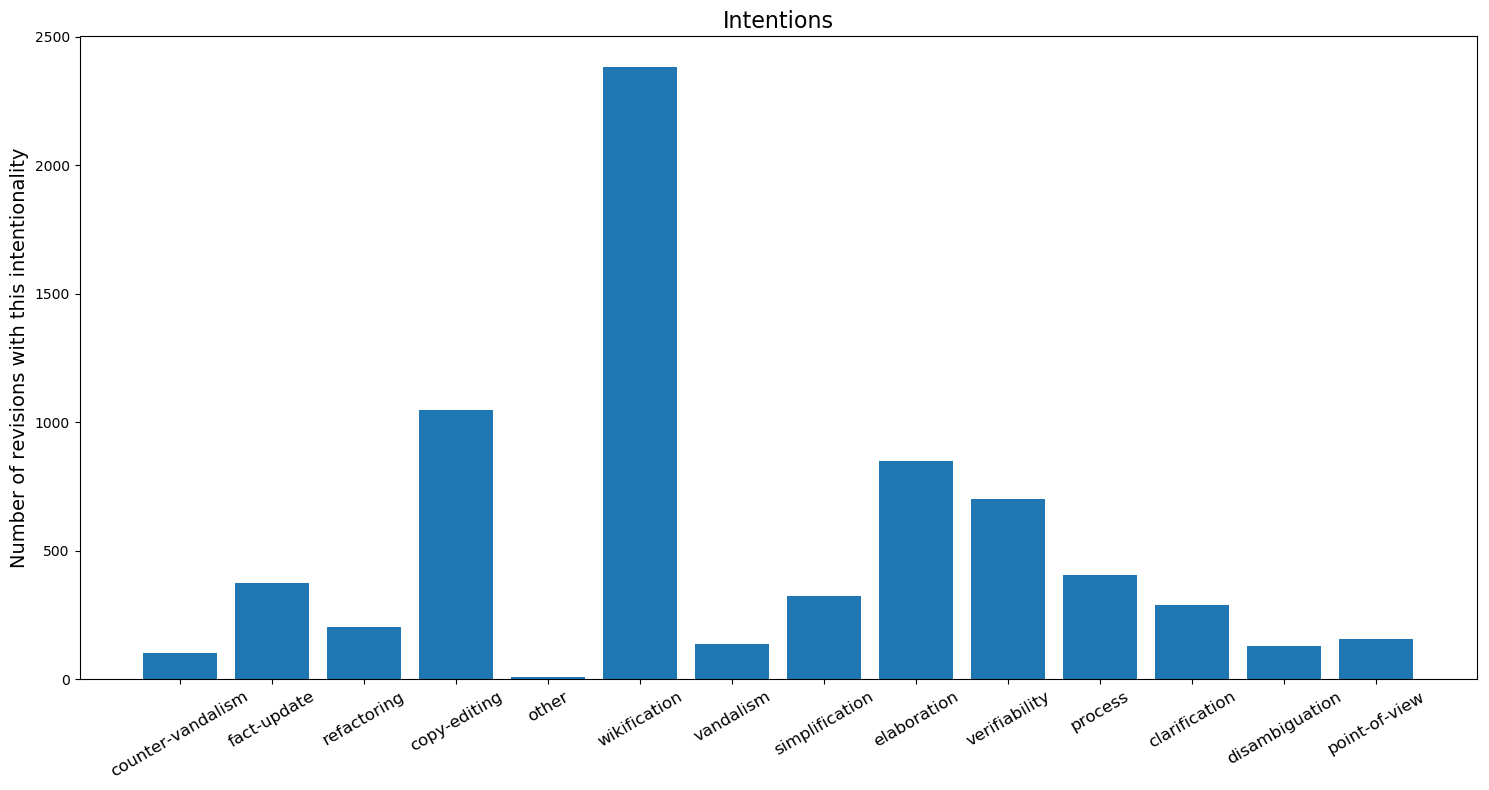

In [25]:
plt.figure(figsize=(15,8))
ax= plt.bar(intentions, dataset.iloc[:,-14:].sum().values)
plt.title("Intentions", fontsize = 16)
plt.ylabel('Number of revisions with this intentionality', fontsize = 14)
plt.xticks(intentions,rotation = 30, fontsize = 12)
plt.tight_layout()
plt.show()


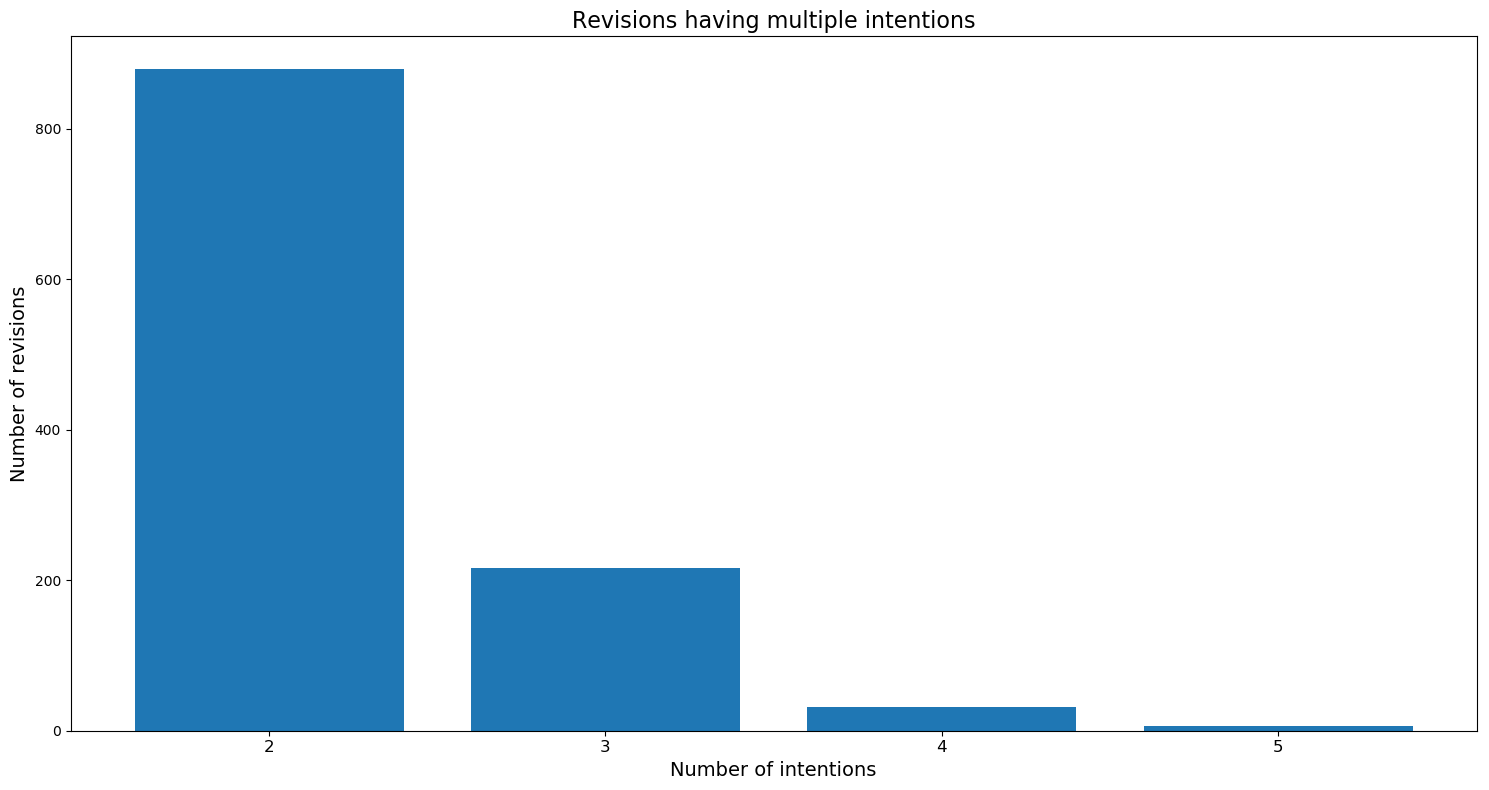

In [26]:
rowSums = dataset.iloc[:,-14:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
plt.figure(figsize=(15,8))
ax = plt.bar(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Revisions having multiple intentions", fontsize = 16)
plt.ylabel('Number of revisions', fontsize = 14)
plt.xlabel('Number of intentions', fontsize = 14)
plt.xticks(multiLabel_counts.index, fontsize = 12)
plt.tight_layout()
plt.show()

Se puede ver que el dataset se encuentra poco balanceado, habiendo una clase con mucha más representación que todas las demás: Wikification. Otras como 'Other' solo aparecen originalmente 2 veces en el dataset. Este número fue ampliado manualmente debido a que algoritmos como ADASYM para realizar oversampling necesitan un n >= 6 en la anterior parte del notebook. En cierta manera incluso podríamos considerar esta categoría un Outlier e ignorarla por completo. Se puede ver también que las intenciones no son excluyentes entre sí, habiendo 879 revisiones con 2 intenciones, aunque el número decrece exponencialmente según aumenta el número de intenciones por cada revisión, tocando un mínimo de 6 revisiones con 5 intenciones.

Llegados a este punto comenzamos con la creación de un modelo que será utilizado de vaselina para evaluar los demás. El  algoritmo utilizado ha sido de nuevo el DummyClassifier por su simplicidad de uso

In [14]:
dummy_ML_data = pandas.DataFrame()


    
baseline_model = DummyClassifier(random_state = 64)
baseline_model.fit(X_train, y_train)
    
y_pred = baseline_model.predict(X_test)
dummy_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
dummy_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
dummy_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
dummy_ML_data.head(15)



,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.084136,0.083625,0.083367,0.207635,0.083367,0.067663


Los resultados obtenidos en general son bástante bajos, teniendo una accuracy de solo un 6%, es decir, solo un 6% de las predicciones son correctas.

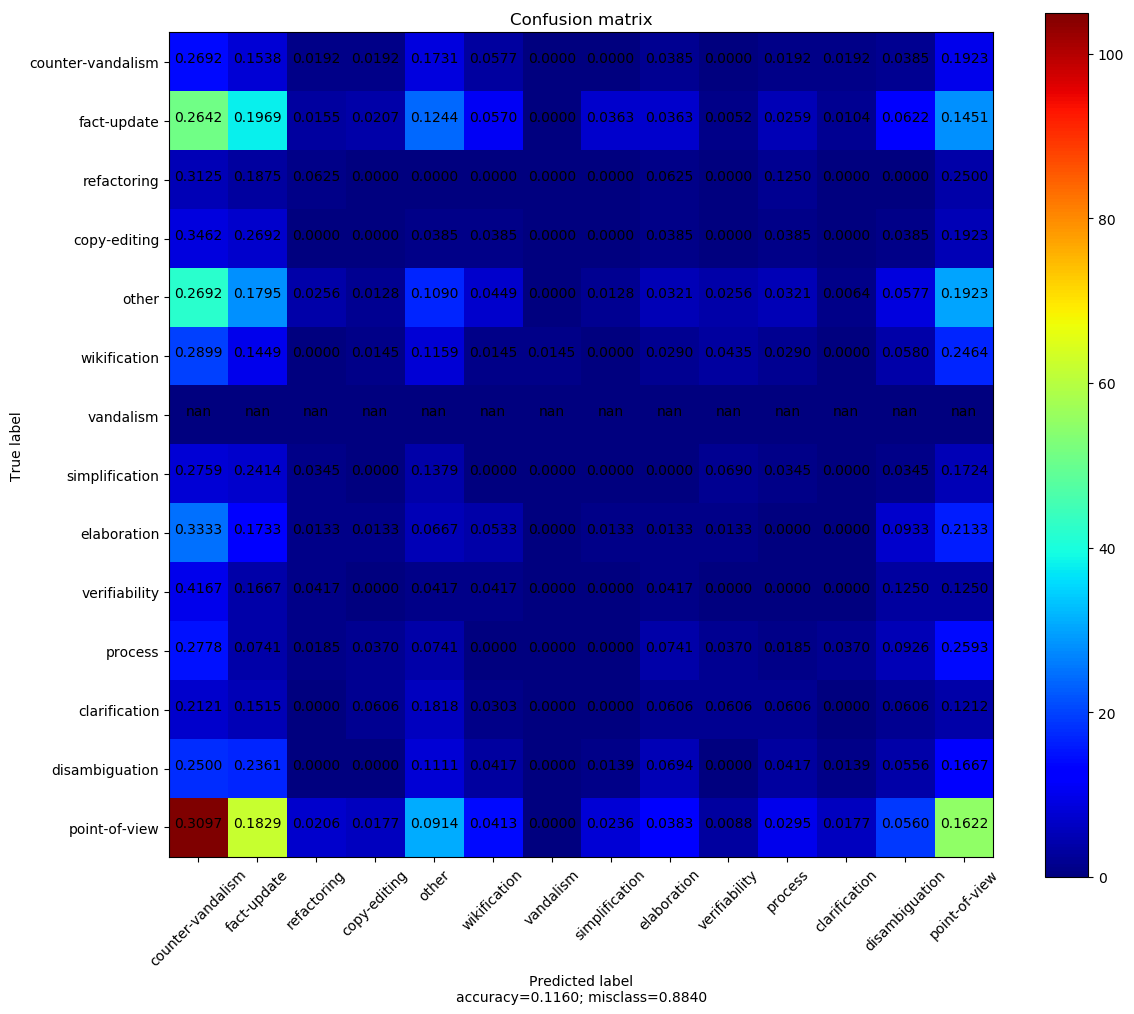

In [69]:
cm_ML_dummy = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_dummy, intentions, normalize = True, cmap = 'jet')


Como vemos el clasificador tiene valores muy bajos en su diagonal. En general el clasificador está clasificando prácticamente de modo aleatorio. Curiosamente la intención "Counter-vandalism" es confundida numerosas veces por las demás intenciones, al igual que point-of-view y fact-update.

Ahora probamos generando un Random Forest

In [29]:
base_rf_ML_data = pandas.DataFrame()


    
base_rf_ML_model = RandomForestClassifier(random_state = 64)
base_rf_ML_model.fit(X_train, y_train)
    
y_pred = base_rf_ML_model.predict(X_test)
base_rf_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_rf_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_rf_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.613507,0.266754,0.34891,0.565102,0.34891,0.403339


Los valores aunque bastante más altos que los del Dummy aún son pobres en general, con un recall muy bajo en comparación con su valor de Precision

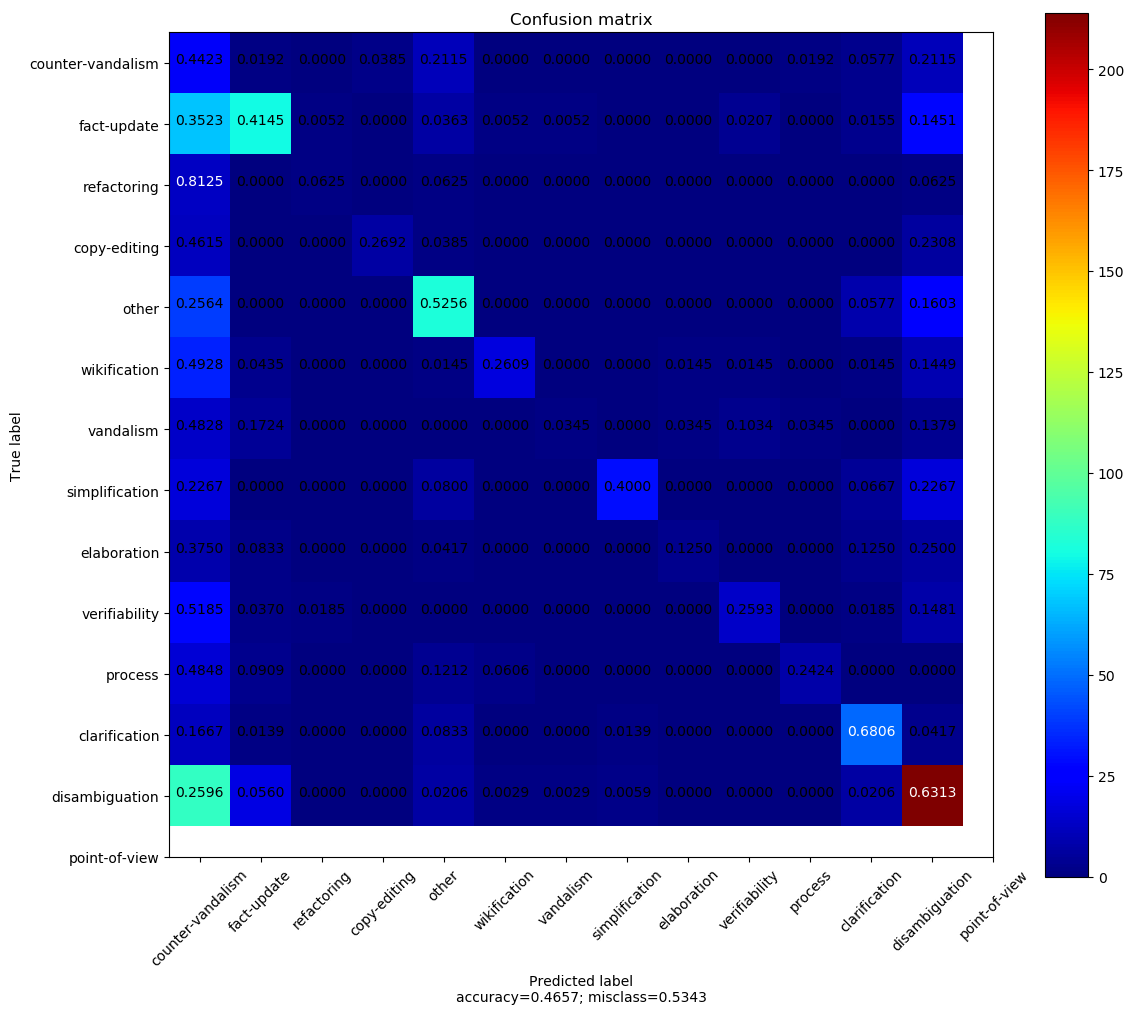

In [30]:
cm_ML_rf = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf, intentions, cmap = 'jet')

Viendo la matriz de confusión vemos que claramente los resultados han mejorado. De modo notable la diagonal principal ya no está compuesta mayoritariamente por 0's, por lo que un % de las intenciones está siendo correctamente clasificado. Aún así, el 50% de los casos se encuentran clasificados incorrectamente. Se aprecia también al igual que en la matriz de confusión del Dummy Classifier que la intención "Point of view" y "Counter-vandalism" es equivocada numerosas veces por todas las demás intenciones. "Counter-vandalism", en mayor medida que "Point of view"

El proximo paso es la versión multilabel del algoritmo predictor KNN

In [31]:
base_KNN_ML_data = pandas.DataFrame()


    
base_KNN_ML_model = MLkNN()
base_KNN_ML_model.fit(X_train, y_train)
    
y_pred = base_KNN_ML_model.predict(X_test)
base_KNN_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_KNN_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_KNN_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_KNN_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.395635,0.100178,0.145273,0.263557,0.145273,0.167838


Como podemos ver sus resultados aún mayores que los del Dummy classifier son al igual pobres, acertando solo un 16% de las labels

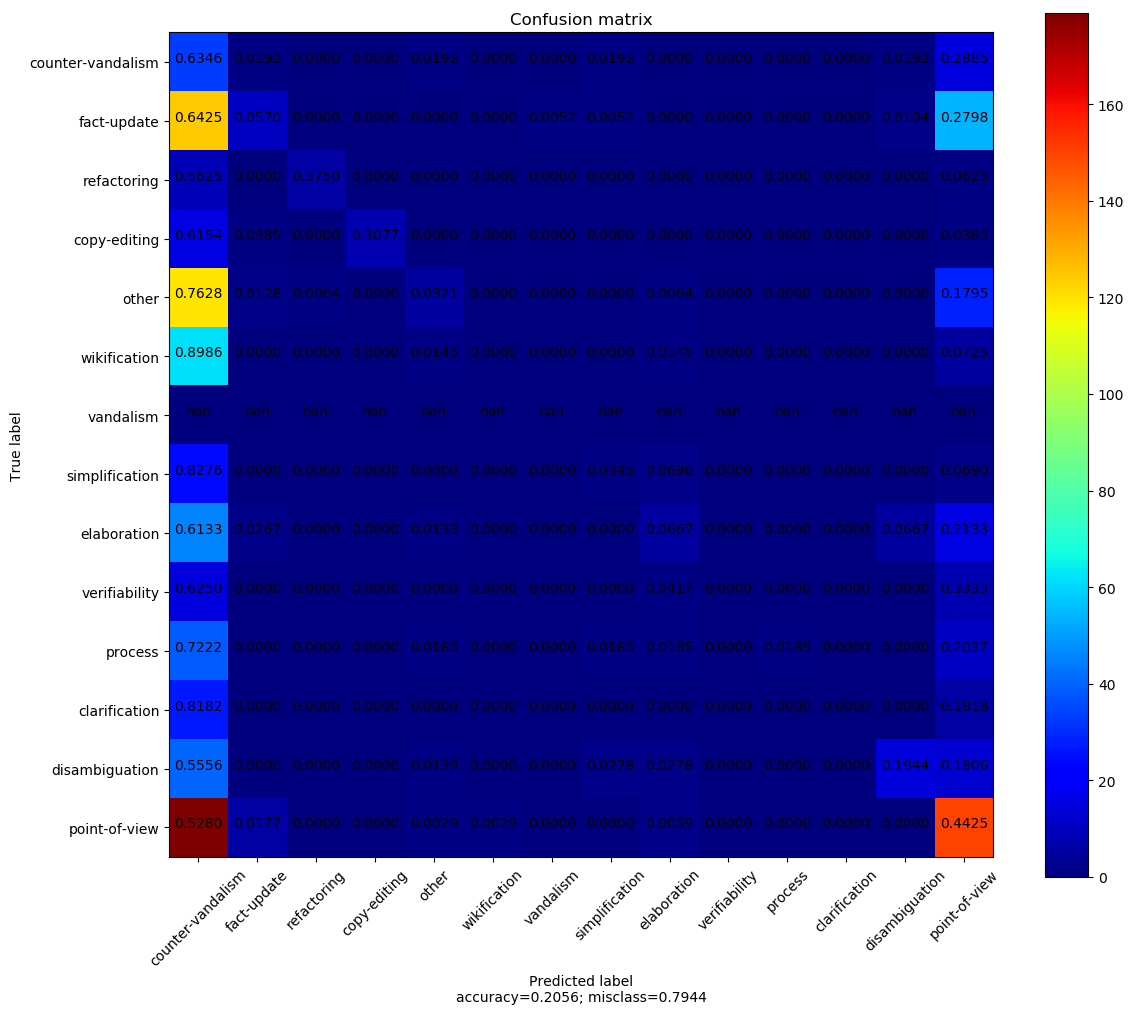

In [32]:
cm_ML_KNN = confusion_matrix(y_test.argmax(axis=1), y_pred.toarray().argmax(axis=1))

plot_confusion_matrix(cm_ML_KNN, intentions, cmap = 'jet')

La matriz de confusión en este caso nos permite ver claramente que el algoritmo confunde las diferentes intenciones. De nuevo counter-vandalism y point-of-view destacan por sus clasificaciones incorrectas.  En el caso de Counter-vandalism el problema es grave pues confunde un porcentaje muy alto de todas las labels son incorrectamente clasificadas como tal.

In [33]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)

base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN
Precision,0.084136,0.613507,0.395635
Recall,0.083625,0.266754,0.100178
F1 Score,0.083367,0.348910,0.145273
F1 micro,0.207635,0.565102,0.263557
F1 macro,0.083367,0.348910,0.145273
Accuracy,0.067663,0.403339,0.167838


En general y comparando los 3 algoritmos podemos ver que aunque ambos han superado los valores del dummy, el Random Forest tiene los mejores valores en general con diferencia. Ahora se probarán diferentes técnicas para mejorar esos valores del Random Forest y también del algoritmo KNN.

Una de las posibilidades para incrementar los valores es mediante el uso de Feature Engineering, dado que a KNN no se puede aplicar, se aplicará al Random Forest siguiendo la estrategia model-based donde el propio Random Forest escoge que variables son más utiles en base a un threshold dado.

In [34]:
base_rf_ML_fe_data = pandas.DataFrame()

#Step to perform feature engineering with the model-based approach
select = SelectFromModel(
RandomForestClassifier(random_state = 64),
threshold=0.01)
    
select.fit(X_train, y_train)
#Creation of the new train set with the selected attributes
X_train_l1 = select.transform(X_train)
    
#Creation of the model that will fit the data
base_rf_ML_fe_model = RandomForestClassifier(random_state = 64)
X_test_l1 = select.transform(X_test)
base_rf_ML_fe_model.fit(X_train_l1, y_train)
#Calculating the score of the model in the test set with the selected features only
    
y_pred = base_rf_ML_fe_model.predict(X_test_l1)
base_rf_ML_fe_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
base_rf_ML_fe_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
base_rf_ML_fe_data['Accuracy'] = [accuracy_score(y_test, y_pred)]
    
base_rf_ML_fe_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.754929,0.288348,0.383403,0.57004,0.383403,0.40246


Se puede ver que los resultados aumentan ligeramente, siendo más notoria la mejoría en la precision.

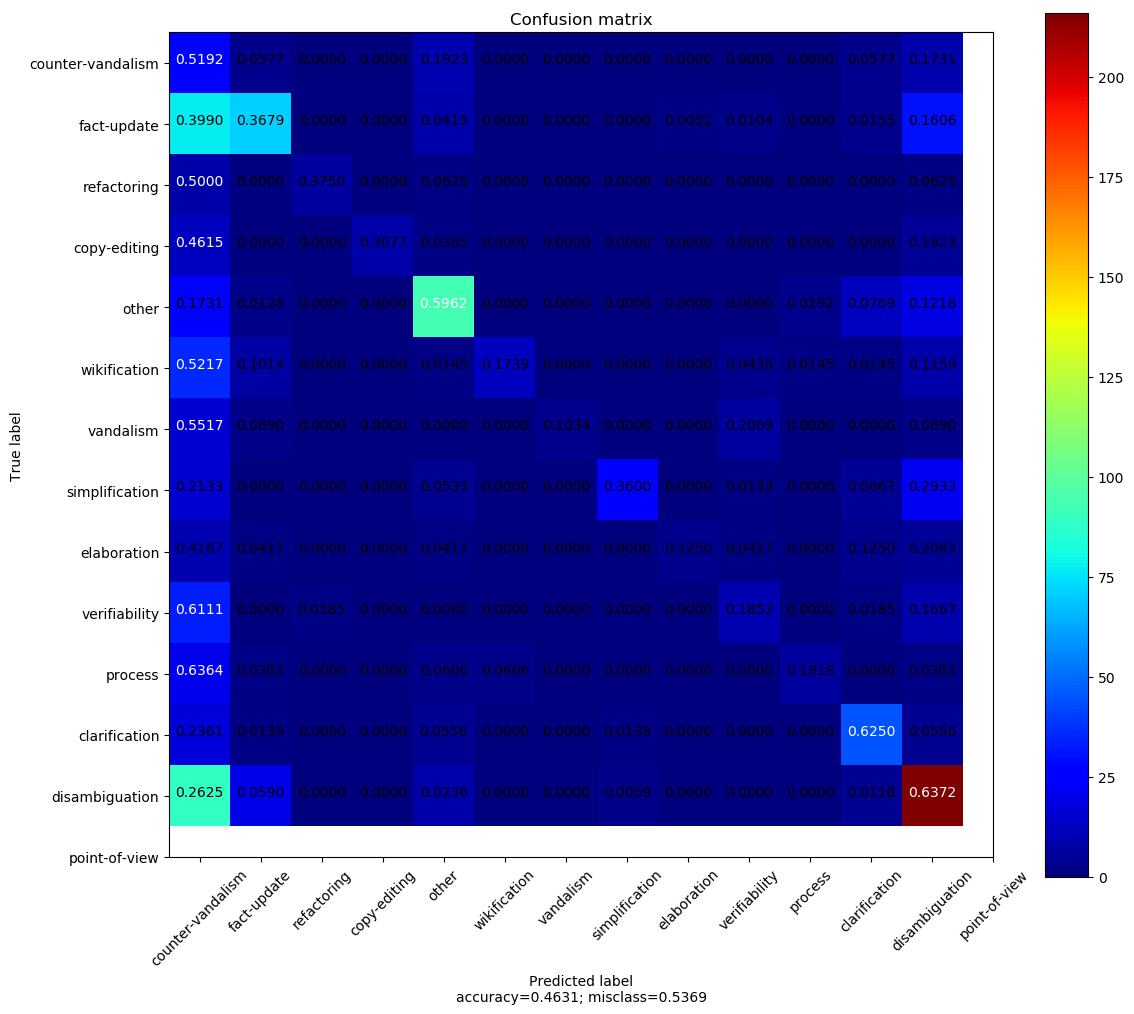

In [35]:
cm_ML_rf_fe = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf_fe, intentions, cmap = 'jet')

El problema de la misclasificación con Point of view y Counter-vandalism persiste, sin embargo al igual que antes los resultados observados en su diagonal principal son los más prometedores de entre los obtenidos

In [36]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)

base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['RF with Feature Engineering'] = base_rf_ML_fe_data.as_matrix()[0,:]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN,RF with Feature Engineering
Precision,0.084136,0.613507,0.395635,0.754929
Recall,0.083625,0.266754,0.100178,0.288348
F1 Score,0.083367,0.348910,0.145273,0.383403
F1 micro,0.207635,0.565102,0.263557,0.570040
F1 macro,0.083367,0.348910,0.145273,0.383403
Accuracy,0.067663,0.403339,0.167838,0.402460


En definitiva, el modelo de Random Forest con Feature Engineering es el que tiene mejor rendimiento en todas las métricas medidas menos en Accuracy con una diferencia de 0,001.
Ahora, se van a realizar tuning de los hiperparámetros de KNN y RF para determinar finalmente el mejor modelo. Se realizará 10Fold-Cross validation tanto en KNN como en RF, pero el RF además hará uso de Feature engineering.

Para realizar esto será utilizado GridSeach por ser la opción mas eficiente, además de un Pipeline en caso del Random Forest para realizar el feature engineering. La opción de los algoritmos genéticos fue probada pero su eficiencia era muchísimo menor pues tras horas y horas de compilación, nunca finalizó, por lo que algún problema había con el tipo de datos.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
                ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64),
                    threshold=0.01)),
                ('classifier', RandomForestClassifier(random_state = 64))])

parameters_ML_RF = {'classifier__n_estimators' : [1,2,4,8,16,32,64,128,256,512]}

tuning_rf_ML_data = pandas.DataFrame()

grid_rf_ML = GridSearchCV(pipeline, parameters_ML_RF, cv = 10, scoring = 'f1_macro')
#fitted on the train set specific for each intention
grid_rf_ML.fit(X_train,y_train)
grid_rf_results = pandas.DataFrame(grid_rf_ML.cv_results_) 
"""
#Predictions of the train set (expected to see clear overfitting in the results as im predicting the train set)
tuning_rf_ea_model = EvolutionaryAlgorithmSearchCV(estimator=RandomForestClassifier(random_state = 64),
                                   params=parameters_ML_RF,
                                   scoring="f1_macro",
                                   cv=StratifiedKFold(n_splits=10),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
tuning_rf_ea_model.fit(X_train,y_train)

"""

#Now we predict the labels for the new test set and calculate its roc_auc score
y_pred = grid_rf_ML.predict(X_test)

tuning_rf_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
tuning_rf_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
tuning_rf_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
tuning_rf_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
tuning_rf_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
tuning_rf_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]


grid_rf_results.head(150)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.255603,0.011035,0.001562,0.004686,1,{'classifier__n_estimators': 1},0.331161,0.365990,0.333182,0.382270,...,0.763905,0.777859,0.772573,0.776906,0.761417,0.770326,0.762932,0.764631,0.770263,0.006186
1,0.261543,0.008209,0.005085,0.006996,2,{'classifier__n_estimators': 2},0.269267,0.341152,0.278173,0.308286,...,0.735566,0.753646,0.745387,0.749081,0.740457,0.738513,0.745563,0.734317,0.745778,0.008204
2,0.298366,0.008412,0.001562,0.004686,4,{'classifier__n_estimators': 4},0.318528,0.394255,0.331767,0.328097,...,0.851446,0.860075,0.854309,0.859912,0.858242,0.864443,0.863089,0.861936,0.858694,0.004240
3,0.371786,0.009373,0.007811,0.007811,8,{'classifier__n_estimators': 8},0.311133,0.398369,0.376049,0.345073,...,0.927361,0.923694,0.924844,0.924156,0.924265,0.926691,0.928479,0.922007,0.926419,0.003385
4,0.510819,0.018550,0.014063,0.004688,16,{'classifier__n_estimators': 16},0.323575,0.419826,0.408638,0.354731,...,0.968248,0.967531,0.966616,0.967835,0.967491,0.969219,0.967596,0.966813,0.968270,0.001420
5,0.806520,0.015982,0.017188,0.004685,32,{'classifier__n_estimators': 32},0.325681,0.410503,0.391220,0.373713,...,0.991790,0.990731,0.989922,0.990693,0.991113,0.991425,0.991376,0.990133,0.991074,0.000651
6,1.351288,0.042612,0.034369,0.006255,64,{'classifier__n_estimators': 64},0.333305,0.405697,0.386231,0.365325,...,0.998759,0.999488,0.998773,0.999232,0.999236,0.999353,0.998441,0.998781,0.999032,0.000317
7,2.465048,0.078357,0.066270,0.006232,128,{'classifier__n_estimators': 128},0.344135,0.423250,0.377952,0.375759,...,1.000000,1.000000,0.999931,1.000000,0.999763,0.999763,0.999753,0.999751,0.999896,0.000115
8,4.691768,0.158095,0.133847,0.010168,256,{'classifier__n_estimators': 256},0.340691,0.397925,0.375838,0.380059,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,9.115669,0.299542,0.261622,0.006320,512,{'classifier__n_estimators': 512},0.344302,0.419036,0.378884,0.388362,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [45]:
tuning_rf_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.768971,0.302914,0.388834,0.602669,0.388834,0.434095


Los resultados han mejorado visiblemente, aunque aún son generalmente pobres, especialmente el Recall siendo de tan solo 0,3.

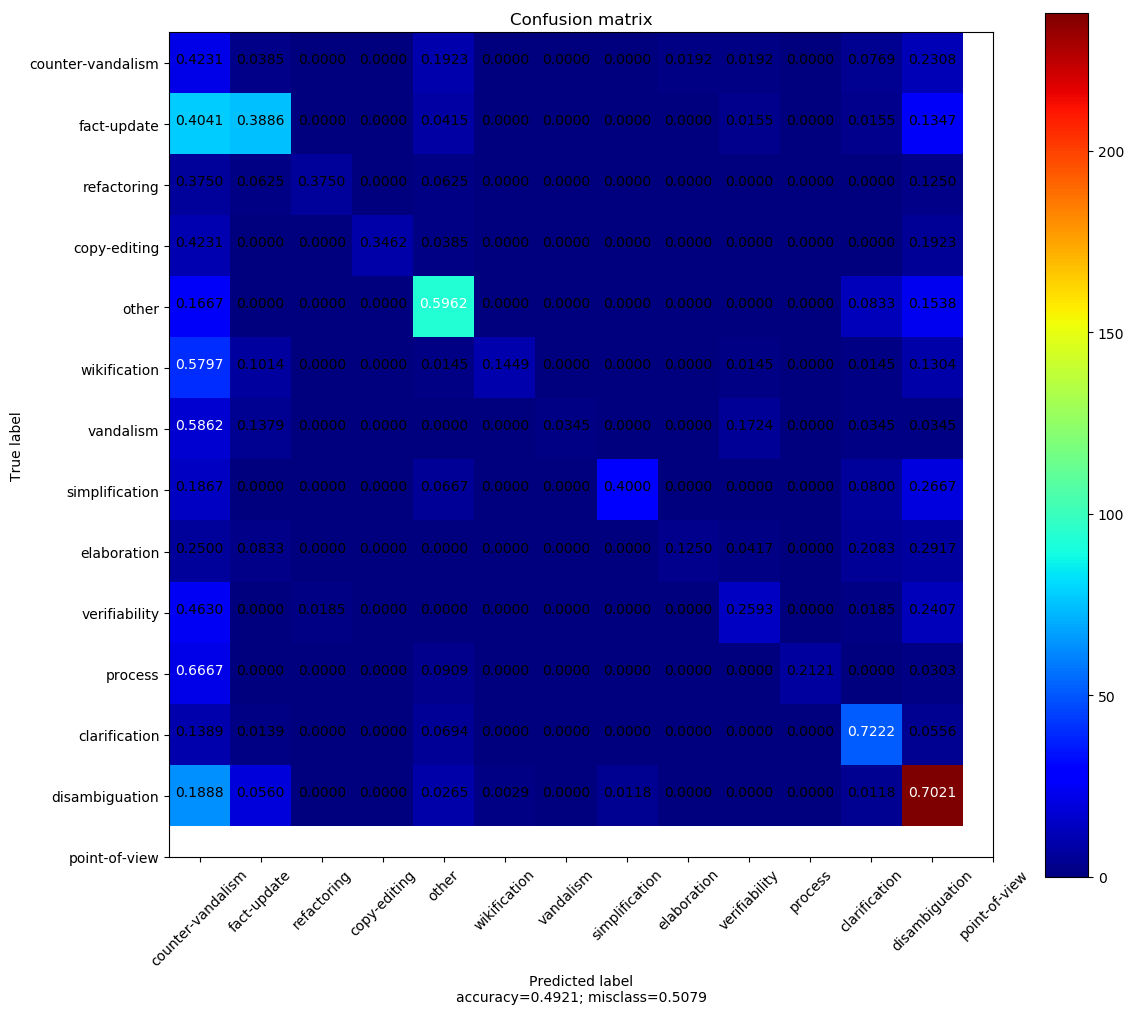

In [51]:
cm_ML_rf_tuning = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm_ML_rf_tuning, intentions, cmap = 'jet')

La matriz de confusión es practicamente la misma que antes de realizar el tuning de los hiperparámetros

In [52]:
parameters_ML_KNN = {'k' : [1,2,3,4,5,6,7,8,9,10,15,20,25,30], 's' : [0.001,0.01,0.1,1,10,100]}


tuning_KNN_ML_data = pandas.DataFrame()

grid_KNN_ML = GridSearchCV(MLkNN(), parameters_ML_KNN, cv = 10, scoring = 'f1_macro')
#fitted on the train set specific for each intention
grid_KNN_ML.fit(X_train,y_train)
grid_KNN_results = pandas.DataFrame(grid_KNN_ML.cv_results_) 


#Predictions of the train set (expected to see clear overfitting in the results as im predicting the train set)

#Now we predict the labels for the new test set and calculate its roc_auc score
y_pred = grid_KNN_ML.predict(X_test)

tuning_KNN_ML_data['Precision'] = [precision_score(y_test, y_pred, average = 'macro')]
tuning_KNN_ML_data['Recall'] = [recall_score(y_test, y_pred, average = 'macro')]
tuning_KNN_ML_data['F1 Score'] = [f1_score(y_test, y_pred, average = 'macro')]
tuning_KNN_ML_data['F1 micro'] = [f1_score(y_test, y_pred, average = 'micro')]
tuning_KNN_ML_data['F1 macro'] = [f1_score(y_test, y_pred, average = 'macro')]
tuning_KNN_ML_data['Accuracy'] = [accuracy_score(y_test, y_pred)]


grid_KNN_results.head(150)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_k,param_s,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.813929,0.069556,0.239565,0.014383,1,0.001,"{'k': 1, 's': 0.001}",0.259660,0.303234,0.197463,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,1.773585,0.018663,0.230428,0.006288,1,0.01,"{'k': 1, 's': 0.01}",0.259660,0.303234,0.197463,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,1.779444,0.020338,0.230297,0.006378,1,0.1,"{'k': 1, 's': 0.1}",0.259660,0.303234,0.197463,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,1.807726,0.053561,0.233968,0.007065,1,1,"{'k': 1, 's': 1}",0.259660,0.303234,0.197463,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,1.918446,0.226760,0.240186,0.014972,1,10,"{'k': 1, 's': 10}",0.259660,0.303234,0.197463,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,1.789345,0.024344,0.233450,0.004342,1,100,"{'k': 1, 's': 100}",0.259660,0.231805,0.197463,...,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.000000
6,1.864360,0.016644,0.237243,0.006685,2,0.001,"{'k': 2, 's': 0.001}",0.223544,0.256996,0.188470,...,0.644161,0.588658,0.619741,0.633572,0.591343,0.659427,0.615914,0.633001,0.620412,0.021322
7,1.876548,0.020054,0.237084,0.006415,2,0.01,"{'k': 2, 's': 0.01}",0.223544,0.256996,0.188470,...,0.644161,0.588658,0.619741,0.633572,0.591343,0.659427,0.615914,0.633001,0.620412,0.021322
8,1.863200,0.021185,0.235424,0.004763,2,0.1,"{'k': 2, 's': 0.1}",0.223544,0.256996,0.188470,...,0.644161,0.588658,0.619741,0.633572,0.591343,0.659427,0.615914,0.633001,0.620412,0.021322
9,1.878630,0.027870,0.241595,0.007583,2,1,"{'k': 2, 's': 1}",0.223544,0.264820,0.188470,...,0.644161,0.545715,0.619741,0.601522,0.540864,0.613614,0.615914,0.633001,0.599865,0.033256


In [53]:
tuning_KNN_ML_data.head(15)

,Precision,Recall,F1 Score,F1 micro,F1 macro,Accuracy
0,0.228518,0.235253,0.230274,0.323716,0.230274,0.254833


Los resultados aunque han mejorado en algunos casos casi duplicandose como el recall, siguen siendo pobres en general, por lo que el clasificador KNN en definitiva, no tiene un alto rendimiento.

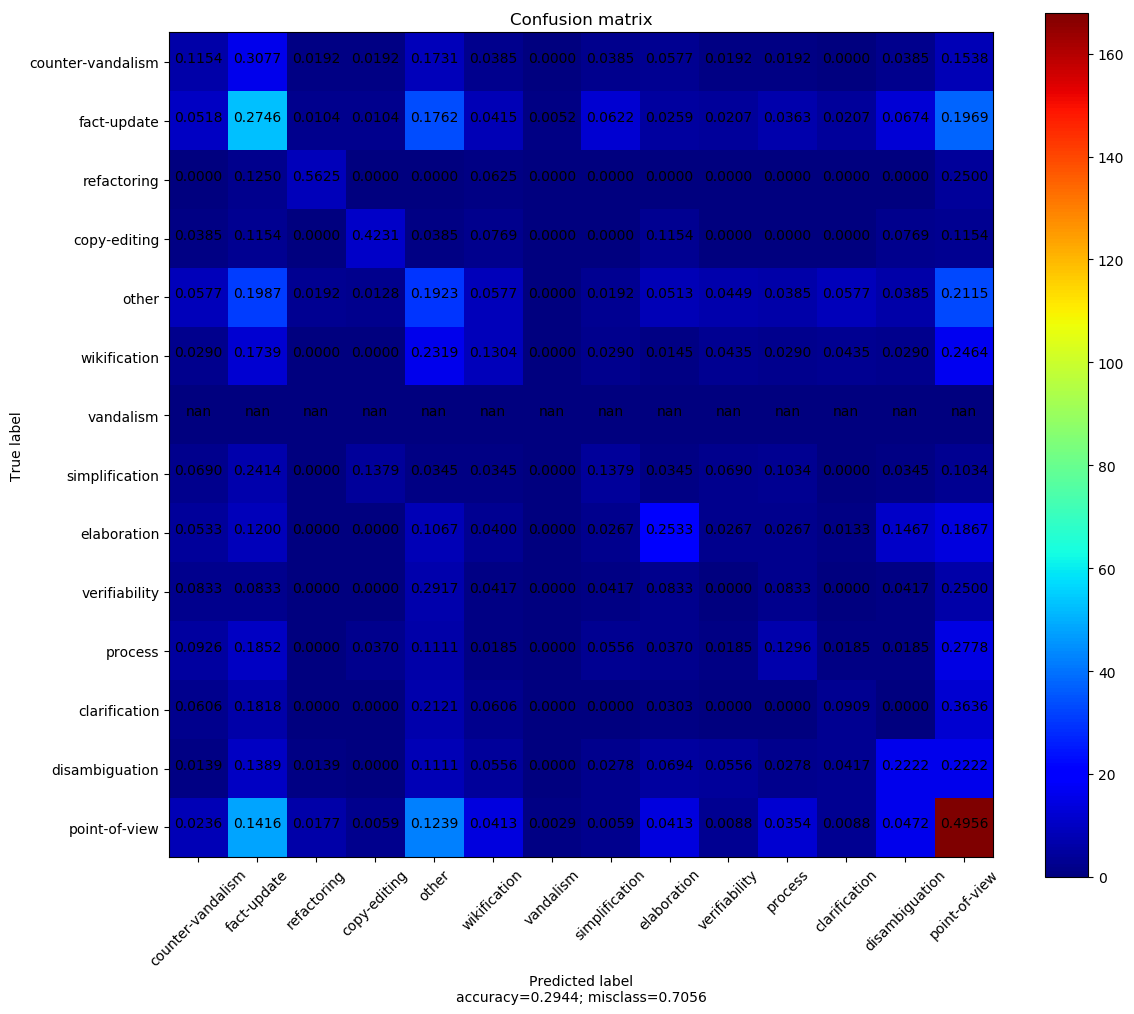

In [54]:
cm_ML_KNN_tuning = confusion_matrix(y_test.argmax(axis=1), y_pred.toarray().argmax(axis=1))

plot_confusion_matrix(cm_ML_KNN_tuning, intentions, cmap = 'jet')

Algo interesante que se puede ver es que ya no está el clasificador asignando erroneamente el label counter-vandalism, sin embargo su diagonal principal refleja lo que estaba claro: la cantidad de misclasificaciones es muy alta.

In [57]:
base_models_ML_data_comp = pandas.DataFrame(index = dummy_ML_data.iloc[:,:].columns)
base_models_ML_data_comp['Dummy classifier'] = dummy_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Random Forest classifier'] = base_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['ML KNN'] = base_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['RF with Feature Engineering'] = base_rf_ML_fe_data.as_matrix()[0,:]
base_models_ML_data_comp['Tuned Random Forest with Feature Engineering'] = tuning_rf_ML_data.as_matrix()[0,:]
base_models_ML_data_comp['Tuned MLKNN'] = tuning_KNN_ML_data.as_matrix()[0,:]
base_models_ML_data_comp.head(15)

,Dummy classifier,Random Forest classifier,ML KNN,RF with Feature Engineering,Tuned Random Forest with Feature Engineering,Tuned MLKNN
Precision,0.084136,0.613507,0.395635,0.754929,0.768971,0.228518
Recall,0.083625,0.266754,0.100178,0.288348,0.302914,0.235253
F1 Score,0.083367,0.348910,0.145273,0.383403,0.388834,0.230274
F1 micro,0.207635,0.565102,0.263557,0.570040,0.602669,0.323716
F1 macro,0.083367,0.348910,0.145273,0.383403,0.388834,0.230274
Accuracy,0.067663,0.403339,0.167838,0.402460,0.434095,0.254833


Comparando todos los modelos generados hasta este punto y sus datos vemos como tanto el KNN como el Random Forest tienen mejor rendimiento que el Dummy classifier, sin embargo ek RF tiene un rendimiento mucho mayor que el KNN, duplicando sus valores de accuracy, f1 micro y prácticamente macro y una precisión mucho mayor. 

En la celda siguiente se encuentran funciones definidas para usar a lo largo del notebook

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#This is used numerous times throughout the notebook to generate the roc_auc scores easily 
#The roc_auc scores are calculated in order to be plotted
#source: Ignacio Garcia antonio caparrini y laura perez. e-prints.
def calculate_roc(model, X, y):
    
    y_pred = model.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

#This method creates a "y" dataset with multilabel format instead of the original with each intention separated
#source: Ignacio Garcia
def creating_multilabel(y):
    
    labels = [None] * len(y.index)

    #output = pandas.DataFrame.to_dict(output)

    for intention in intentions:

        offset = 0

        for line in y[intention]:

            if labels[offset] == None:
                labels[offset] = []
            if line == 1:
                labels[offset].append(str(intention))

            offset += 1

    return labels

#source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()